# Social Graphs: Explainer Notebook

In [8]:
import pandas as pd
import json
import urllib
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import glob
import PIL as PIL
import powerlaw

from fa2 import ForceAtlas2
import plotly.express as px
import plotly.graph_objects as go
sns.set()

from statistics import mean
from scipy import stats
from collections import Counter

from fa2 import ForceAtlas2
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize 
from nltk import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


[nltk_data] Downloading package wordnet to /Users/philip/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/philip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/philip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Motivation

### What is your dataset?
In this notebook, we will explore a dataset composed from the *Avatar: The Last Airbender* (ATLA) [fandom wiki](https://avatar.fandom.com/wiki/Avatar_Wiki).
Specifically, the dataset consists of the character pages for all ATLA characters. This includes characters from
the sequel series *The Legend of Korra*. The fandom wiki lists a total of 625 pages related to characters.
The wiki also contains episode transcripts for both series.

For reference, each series consists of invidual seasons denoted *books*. In this notebook we will use *book* and *season* interchangeably unless stated otherwise.

### Why did you choose this particular dataset?
The ATLA dataset is well suited for analysis, both due to the appropriate number of character pages and their individual sizes.
The ATLA universe is also neatly categorized. Each character resides from one of four nations and is capable of *bending* (i.e. manipulating)
one of the four basic elements (water, air, fire and earth).
It was also important that episode transcripts were readily available, since we knew that we wanted
to employ NLP.
Finally, ATLA is a critically acclaimed animation series with a large, passionate fanbase. The authors of this notebook are also fans of the series.
We wish to appease the fans by providing additional ATLA content for consumption.

### What was your goal for the end user's experience?

Our goal is to


## Basic stats

In this section, we will firstly create the dataset through various API calls to the fandom wiki. Afterwards, we can create the character network.
Finally, descriptive statistics and visualizations concerning the dataset and network will take place.

### Extracting characters from Avatar: The Last Airbender fandom wiki

Here the all character names and nationalities from the wiki are extracted. The wiki contains several category pages that we can use for this purpose. Since we are interested in finding the nationality of each character, we will use the following category pages:
- Water Tribe characters
- Earth Kingdom characters
- Fire Nation characters
- United Republic characters

The first four category pages are the archetypical countries in ATLA. The last country, the *United Republic*, is only introduced later on in *The Legend of Korra* and can be seen as an amalgation of the previous four. Using the above pages, the nationality of each character can be found without additional scraping. However, there are also characters that are not associated with a country. In order to find these characters, we will also use the top-level character category page containing **all** character in the universe.

We do a small amount of data-cleaning regarding the characters included. A few characters are exclusive to non-canon video games and pilot episodes. We therefore exclude these.

In [3]:
data = pd.DataFrame({'name': [], 'nationality': []})

In [4]:
url = 'https://avatar.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Characters&cmlimit=500&prop=revisions&rvprop=content&rvslots=*'
base_url = 'https://avatar.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:'
page_titles = ['Water_Tribe_characters', 'Earth_Kingdom_characters', 'Fire_Nation_characters', 'Air_Nation_characters', 'United_Republic_characters', 'Characters']
character_nationalities = ['Water Tribe', 'Earth Kingdom', 'Fire Nation', 'Air Nation', 'United Republic', None]
end_url = '&cmlimit=500&prop=revisions&rvprop=content&rvslots=*&format=json'

for page_title, character_nationality in zip(page_titles, character_nationalities):
    url = base_url + page_title + end_url
    response = urllib.request.urlopen(url)
    page = json.load(response)
    category_members = page['query']['categorymembers']
    
    # Extract page title and character nationality.
    character_names = [item['title'] for item in category_members] 
    
    # Some pages may be longer than 500 members.
    if 'continue' in page.keys():
        cmcont = page['continue']['cmcontinue']
        url = base_url + page_title + end_url + '&cmcontinue=' + cmcont
        response = urllib.request.urlopen(url)
        page = json.load(response)
        category_members = page['query']['categorymembers']
        character_names += [item['title'] for item in category_members] 
        
    
    # Some Category:* items will be included. These are not important, so we can discard them.
    # We also don't want any characters from games or pilot episodes.
    filtered = filter(lambda title: 'Category:' not in title and 'pilot' not in title and 'games' not in title, character_names)
    character_names = list(filtered)

    # Might as well get nationality here.
    name_and_type = {'name': character_names, 'nationality': [character_nationality for _ in character_names]}

    # Merge with existing data frame.
    df = pd.DataFrame.from_dict(name_and_type)
    data = data.append(df)

    
# A few characters can get included multiple times.
data = data.drop_duplicates(subset='name')

# Some entries might have duplicate indices
data = data.reset_index(drop=True)

data.head(10)


,name,nationality
0,Amak,Water Tribe
1,Amon,Water Tribe
2,Arnook,Water Tribe
3,Ashuna,Water Tribe
4,Atuat,Water Tribe
5,Bato,Water Tribe
6,Desna and Eska,Water Tribe
7,Due,Water Tribe
8,Gilak,Water Tribe
9,Hahn,Water Tribe


In [5]:
data.shape

(572, 2)

As seen above, we managed to extract $572$ characters from the category pages. This also means that our network will be close to the same size.

### Downloading character pages

With all character names collected, we can begin extracting individual character pages. The character pages will be used to link character nodes in the network, as done previously in the course. The will also be used to extract additional attributes. The contributors of the wiki have almost completely eliminated the need for disambiguation pages and redirects, making the whole process very simple.

In [7]:
base_url = 'https://avatar.fandom.com/api.php?action=query&titles='
end_url = '&prop=revisions&rvprop=content&rvslots=*&format=json'

if not os.path.exists('characters/'):
    os.makedirs('characters/')

for character_name in data['name'].to_numpy():
    # Create URL
    original_name = character_name
    page_title = character_name.replace(' ', '_')
    
    url = base_url + urllib.parse.quote_plus(page_title) + end_url
    
    # Parse response
    response = urllib.request.urlopen(url)
    page = json.load(response)
    pid = list(page['query']['pages'].keys())[0]
    page_content = page['query']['pages'][pid]['revisions'][0]['slots']['main']['*']
    
    # Save to file
    with open('characters/' + original_name.replace('/', '-') + '.txt', 'w') as file:
        file.write(page_content)

In [7]:
data.to_csv('avatar_data.csv')

In [5]:
data = pd.read_csv('avatar_data.csv')

We'll also need to download the pages as plain text for NLP later on. This is done by adding `&prop=extract&explaintext` to the API call.

In [6]:
base_url = 'https://avatar.fandom.com/api.php?action=query&titles='
end_url = '&prop=extracts&explaintext&format=json'

if not os.path.exists('characters_plain_text/'):
    os.makedirs('characters_plain_text/')

for character_name in data['name'].to_numpy():
    # Create URL
    original_name = character_name
    page_title = character_name.replace(' ', '_')
    
    url = base_url + urllib.parse.quote_plus(page_title) + end_url
    
    # Parse response
    response = urllib.request.urlopen(url)
    page = json.load(response)
    pid = list(page['query']['pages'].keys())[0]
    page_content = page['query']['pages'][pid]['extract']
    
    # Save to file
    with open('characters_plain_text/' + original_name.replace('/', '-') + '.txt', 'w') as file:
        file.write(page_content)

### Extracting links and creating the network

All data collection required for creating the network is now done. We will now traverse each character page and find hyperlinks to other character pages. This will allow us to create the social network for the ATLA universe. Along the way, character attributes will also be extracted.

It's easiest to first create all nodes in our graph and add all the according attributes. The links will be created after this process.
Each character node posseses the following attributes:
- Nationality
- Gender
- Bending style


This code is used for extracting the bending style of a character. We again use the neatly organized category pages from the wiki. Not all characters are capable of bending - those are labelled as `non-bender`s.

In [10]:
url = 'https://avatar.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Characters&cmlimit=1000&prop=revisions&rvprop=content&rvslots=*'
base_url = 'https://avatar.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:'
end_url = '&cmlimit=500&prop=revisions&rvprop=content&rvslots=*&format=json'


def category_to_list(page_title):
    url = base_url + page_title + end_url
    response = urllib.request.urlopen(url)
    page = json.load(response)
    category_members = page['query']['categorymembers']
    
    # Extract page title and character nationality.
    character_names = [item['title'] for item in category_members] 
    
    # Some Category:* items will be included. These are not important, so we can discard them.
    # We also don't want any characters from games or pilot episodes.
    filtered = filter(lambda title: 'Category:' not in title and 'pilot' not in title and 'games' not in title, character_names)
    character_names = list(filtered)
    return character_names

water_benders = category_to_list('Waterbenders')
air_benders = category_to_list('Airbenders')
fire_benders = category_to_list('Firebenders')
earth_benders = category_to_list('Earthbenders')

def bending_art(name):
    if name in water_benders:
        return 'Waterbender'

    if name in earth_benders:
        return 'Earthbender'

    if name in air_benders:
        return 'Airbender'
    
    if name in fire_benders:
        return 'Firebender'
    
    return 'Non-bender'
    

The following code cell firstly creates all character nodes and inserts attributes. The `gender` attribute is the only attribute that requires RegEx for extraction. 

Gender is typically represented like so:
```
| gender = Male
```
making it easy to extract via a RegEx pattern: `\|[\s]*gender[\s]*=[\s]*(\w+)\n`. The pattern takes into account that there may be a varying amount of whitespace between keywords.

In [11]:
G = nx.DiGraph()
gender_pat = r'\|[\s]*gender[\s]*=[\s]*(\w+)\n'
for name, nationality in data[['name', 'nationality']].to_numpy():
    with open('characters/' + name.replace('/', '-') + '.txt', 'r') as file:
        gender = None
        
        page_content = file.read()

        gender_match = re.findall(gender_pat, page_content)
        if gender_match:
            gender = gender_match[0]
        
        bending_style = bending_art(name)
        G.add_node(name, nationality=nationality, gender=gender, bending_art=bending_style)

Now we'll extract the hyperlinks from the character pages and create the links in the network.

The Avatar wiki only uses `[[...]]` links, which makes link extraction significantly easier. This allows us to get by with a single RegEx pattern: 
`\[\[(.*?)(?:#.*?)?(?:\|.*?)?\]\]`. 

The pattern takes a couple of cases into account. Some hyperlinks are of the form `[[<character_name>#<section>]]` and `[[<character_name> | <alias>]]`. In all cases, we are only interested in `<character_name>`. Most hyperlinks are of the most basic form `[[<character_name>]]`.

In [12]:
# Patterns for detecting links
pat1 = r'\[\[(.*?)(?:#.*?)?(?:\|.*?)?\]\]'

for name in data['name'].to_numpy():
    
    # Open the appropriate text file containing character wiki page previously saved
    with open('characters/' + name.replace('/', '-') + '.txt', 'r') as file:
        page_content = file.read()

        # Convert to set to eliminate duplicates
        page_names = set(re.findall(pat1, page_content))

        for page_name in page_names:
            filtered_name = page_name.replace('+', '\+').replace('(', '\(').replace(')', '\)')
            
            # No self referencing either!
            if data['name'].str.fullmatch(filtered_name).any() and filtered_name != name:
                G.add_edge(name, page_name)

Finding relations for Amak
Finding relations for Amon
Finding relations for Arnook
Finding relations for Ashuna
Finding relations for Atuat
Finding relations for Bato
Finding relations for Desna and Eska
Finding relations for Due
Finding relations for Gilak
Finding relations for Hahn
Finding relations for Hakoda
Finding relations for Hama
Finding relations for Hiryu
Finding relations for Hotah
Finding relations for Huu
Finding relations for Iknik Blackstone Varrick
Finding relations for Kam
Finding relations for Kanna
Finding relations for Katara
Finding relations for Kinto
Finding relations for Kirima
Finding relations for Korra
Finding relations for Kuruk
Finding relations for Kya
Finding relations for Kya (nonbender)
Finding relations for La
Finding relations for Lirin
Finding relations for Malina
Finding relations for Maliq
Finding relations for Naga
Finding relations for Nini
Finding relations for Niyok
Finding relations for Noa
Finding relations for Nutha
Finding relations for Pa

With all links created, let us inspect the final graph briefly.

In [13]:
print('Number of nodes:', G.number_of_nodes())
print('Number of links:', G.number_of_edges())

Number of nodes: 572
Number of links: 6274


We find the network to contain $572$ nodes and $6274$ links. The number of nodes is exactly as expected, as this was the number of character pages found. We find the number of links to be relatively large. It appears that characters in the ATLA universe are, on average, well connected.

Let us now create the GCC. Here we hope that the GCC is not significantly smaller, as that could cause issues. We don't want a network containing very few nodes.

In [14]:
component_list = sorted(nx.weakly_connected_components(G), key=len, reverse=True)
GCC = G.subgraph(component_list[0]).copy()

And let us inspect it as before:

In [15]:
print('Number of nodes:', GCC.number_of_nodes())
print('Number of links:', GCC.number_of_edges())

Number of nodes: 571
Number of links: 6274


We find this to be a success. The GCC only contains 1 node less than the original network. This is perhaps surprising in itself. It indicates that nearly *all* characters are connected and part of a single component.

### Extracting character dialogue from episode transcripts


Since we wish to perform NLP, we will need dialogue associated with each chararcter. The fandom wiki contains transcripts for each episode of both series, which we will use for this purpose. This will require some fiddling, but is overall not particularly difficult.

Our first job is finding the name, book and episode number of each episode. The wiki contains a page for each season of a series. These pages include all episodes of their corresponding season (book) and associated data.

The first series, *Avatar: The Last Airbender*, contains in total 3 books:
- Book One: Water
- Book Two: Earth
- Book Three: Fire

The second series, *The Legend of Korra*, contains in total 4 books:
- Book One: Air
- Book Two: Spirits
- Book Three: Change
- Book Four: Balance

For example, here is an small excerpt from the page regarding the first season of ATLA:

```
| {{Episode box
| series   = 1
| number   = 101
| name     = The Boy in the Iceberg
| image    = Aang in the iceberg.png
| airdate  = February 21, 2005
| writer   = [[Michael Dante DiMartino]], [[Bryan Konietzko]]
| director = [[Dave Filoni]]
| summary  = [[Sokka]] and [[Katara]], two teenage siblings living in the South Pole, discover [[Aang]] and his pet [[flying bison]], [[Appa]], trapped in an iceberg. After Katara frees him, she discovers that he is an [[Airbending|airbender]] and the siblings take him to their home village in the [[Southern Water Tribe]]. Meanwhile, his unfreezing attracts the attention of the Fire Nation's [[Zuko]] intent on capturing him.}}
```

The above shows the `Episode box` for the first episode, *The Boy in the Iceberg*. The information we are interested in here is `series` and `name`. `number` is not useful, since we can easily deduce this later on.
We use a simple RegEx pattern to extract the above.

In [21]:
episode_info_df = pd.DataFrame({'name': [], 'book': [], 'book_number': [], 'episode_number': [], 'series': []})

In [22]:
base_url = 'https://avatar.fandom.com/api.php?action=query&titles='
end_url = '&prop=revisions&rvprop=content&rvslots=*&format=json'
page_names = ['Book_One:_Water', 'Book_Two:_Earth', 'Book_Three:_Fire', 'Book_One:_Air', 'Book_Two:_Spirits', 'Book_Three:_Change', 'Book_Four:_Balance']
books = [('Water', '1', '1'), ('Earth', '1', '2'), ('Fire', '1', '3'), ('Air', '2', '1'), ('Spirits', '2', '2'), ('Change', '2', '3'), ('Balance', '2', '4')]

episode_pat = r'\| series   = ([0-9])\s\| number   = [0-9]+\s\| name     = ([\w 0-9 \':,.]+)\s'

for page_name, (book_name, _, book_number) in zip(page_names, books):
    # Episode number is found manually
    episode_number = 1

    # Create URL
    url = base_url + urllib.parse.quote_plus(page_name) + end_url
    
    # Parse response
    response = urllib.request.urlopen(url)
    page = json.load(response)
    pid = list(page['query']['pages'].keys())[0]
    page_content = page['query']['pages'][pid]['revisions'][0]['slots']['main']['*']
    
    episode_names = []
    book_names = []
    book_numbers = []
    episode_numbers = []
    series_numbers = []
    
    # Collect episodes for a book
    matches = re.findall(episode_pat, page_content)
    for match in matches:
        series = match[0]
        episode_name = match[1]
        
        episode_names.append(episode_name)
        book_names.append(book_name)
        book_numbers.append(book_number)
        episode_numbers.append(str(episode_number))
        series_numbers.append(series)
    
    # Append the result
    ep_df = pd.DataFrame({'name': episode_names, 'book': book_names, 'book_number': book_numbers, 'episode_number': episode_numbers, 'series': series_numbers})
    episode_info_df = episode_info_df.append(ep_df, ignore_index=True)
    
    episode_number += 1


In [23]:
episode_info_df.to_csv('episode_info.csv')

In [2]:
episode_info_df = pd.read_csv('episode_info.csv')

In [24]:
episode_info_df.head()

,name,book,book_number,episode_number,series
0,The Boy in the Iceberg,Water,1,1,1
1,The Avatar Returns,Water,1,1,1
2,The Southern Air Temple,Water,1,1,1
3,The Warriors of Kyoshi,Water,1,1,1
4,The King of Omashu,Water,1,1,1


We can now extract the actual transcript data using the dataframe above. Each transcript page simply uses the format `Transcript:<episode_name>`.

We again show a excerpt from a transcript page:
```
|''The episode opens with a reddish sky due to Sozin's Comet as the camera pans to the left. The scene cuts to Ozai throwing a left-curved fire blast, followed with a right-curved blast. He fires a straight blast. Cuts to inside Aang's earth sphere shield as he endures the blasts.''
|-
!Ozai
|[''Yelling out to Aang tauntingly while using a flamethrower blast with his hair swaying in the wind.''] Come on out, Avatar! You can't hide in there forever!
|-
|
|''The scene changes to the airship fleet. Sokka and Toph are running on top of one of three airships.''
|-
!Sokka
|Toph, metalbend the rudder so it's jammed in a turning position. The ship will spiral and slam into the others.
|-
```

As we can see, the transcript is presented in a tabular form, hence the use of `|`. The first line is not attributed to any character, indicating that this is a description of what occurs on screen, making it irrelevant for us. However, we can see that actual dialogue always contains a `!<character_name>` tag before a table entry. In this example, we see dialogue from the characters *Ozai* and *Sokka*. 

The dialogue is extracted using RegEx. We ensure that a only table entries that contain a character tag are included. Nonetheless, there is still a problem with the extracted dialogue, since it also contains scene commentary:
```
!Ozai
|[''Yelling out to Aang tauntingly while using a flamethrower blast with his hair swaying in the wind.''] Come on out, Avatar! You can't hide in there forever!
|-
```

As we see from the above table entry, the scene commentary is contained within `[...]` groups. It's only the text *after* that we are interested in. While the scene commentary can contain semantically relevant information, such as describing a character as visually livid, it is in most cases irrelevant. Therefore, we choose to exclude this commentary completely.

There is also a final problem. The character tags do not always match the names of characters perfectly. For example, a tag could be `!Toph`. However, the character page for *Toph* also includes her last name, *Beifong*. Since all our names are extracted from character pages, this is a problem. Our character dataframe only contains an entry for `Toph Beifong`, and not `Toph`. This would essentially mean that we could never attribute dialogue to *Toph*. That would be a major problem, since she is a major character in the series. To fix this issue, we search for names *containing* the character tag, and find the first match.

In [25]:
transcript_df = pd.DataFrame({'series': [], 'episode_name': [], 'book': [], 'book_number': [], 'episode_number': [], 'character_name': [], 'dialogue': []})
base_url = 'https://avatar.fandom.com/api.php?action=query&titles='
end_url = '&prop=revisions&rvprop=content&rvslots=*&format=json'

transcript_pat = r'!([\w \']+)\s\|([\w .\'\[\]\-!?,\s\":]+)\s\|(?:-\s|})'
commentary_pat = r'(\[''(?:.*?)''\])'

for series, episode_name, book, book_number, episode_number in episode_info_df[['series', 'name', 'book', 'book_number', 'episode_number']].to_numpy():
    # Edge case: some episodes are disambigiuated
    if episode_name == 'The Revelation' or episode_name == 'Harmonic Convergence':
        episode_name += ' (episode)'

    page_name = 'Transcript:' + episode_name.replace(' ', '_')
    # Create URL
    url = base_url + urllib.parse.quote_plus(page_name) + end_url
    
    # Parse response
    response = urllib.request.urlopen(url)
    page = json.load(response)
    pid = list(page['query']['pages'].keys())[0]
    page_content = page['query']['pages'][pid]['revisions'][0]['slots']['main']['*']

    character_names = []
    character_dialogues = []
    
    # Extract dialogue
    matches = re.findall(transcript_pat, page_content)
    for match in matches:
        character_name = match[0]
        character_dialogue = match[1]

        # Character dialogue also contains commentary marked in [''...'']. We want to remove this.
        commentary_matches = re.findall(commentary_pat, character_dialogue)
        for commentary_match in commentary_matches:
            character_dialogue = character_dialogue.replace(commentary_match, '')
        
        # Remove redundant whitespace.
        character_dialogue = ' '.join(character_dialogue.split())

        # Character names don't always match exactly when given in the transcripts. We'll just choose the closest name if available.
        character_name_match = data.name.str.extract('(' + character_name + ')', expand=False).dropna()
        if len(character_name_match) > 0:
            character_name = character_name_match.iloc[0]
            
        character_names.append(character_name)
        character_dialogues.append(character_dialogue)
    
    episode_names = [episode_name for _ in character_names]
    books = [book for _ in character_names]
    book_numbers = [book_number for _ in character_names]
    episode_numbers = [episode_number for _ in character_names]
    series_numbers = [series for _ in character_names]

    transcript_dict = {'series': series_numbers, 'episode_name': episode_names, 'book': books, 'book_number': book_numbers, 'episode_number': episode_numbers, 'character_name': character_names, 'dialogue': character_dialogues}
    transcript_df = transcript_df.append(pd.DataFrame(transcript_dict), ignore_index=True)

transcript_df = transcript_df.dropna()
transcript_df.head(5)    
    
    


,series,episode_name,book,book_number,episode_number,character_name,dialogue
0,1,The Boy in the Iceberg,Water,1,1,Sokka,It's not getting away from me this time. Watch...
1,1,The Boy in the Iceberg,Water,1,1,Katara,"Sokka, look!"
2,1,The Boy in the Iceberg,Water,1,1,Katara,"But, Sokka! I caught one!"
3,1,The Boy in the Iceberg,Water,1,1,Katara,Hey!
4,1,The Boy in the Iceberg,Water,1,1,Sokka,Why is it that every time ''you'' play with ma...


This concludes the extraction of character dialogue. The above dataframe contains all relevant information we need going forwards, such episode names, character names and associated dialogue.

In [26]:
transcript_df.to_csv('atla_lok_transcript.csv')

In [3]:
transcript_df = pd.read_csv('atla_lok_transcript.csv')

In [4]:
transcript_df = transcript_df.dropna()

### Number of episodes per season and per series
Going forward it will be important to know the length of each series. Recall that that ATLA consists of two series: *Avatar: The Last Airbender* (the first series) and the sequel *The Legend of Korra*.

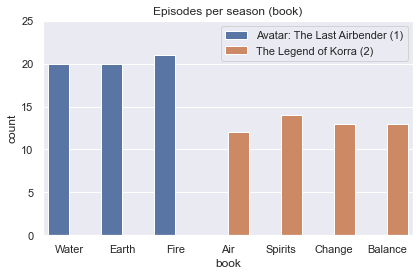

In [44]:
sns.countplot(x='book', hue='series', data=episode_info_df)
plt.yticks([i * 5 for i in range(6)])

plt.legend(labels=['Avatar: The Last Airbender (1)', 'The Legend of Korra (2)'])
plt.title('Episodes per season (book)')
plt.tight_layout()
plt.show()

The above plot shows that the first series contains one fewer season, but has on average more episodes per season than the second series. 
Additionally, the number of *total* episodes per series is also shown below:

In [48]:
episode_info_df.groupby('series').count().drop(columns=['Unnamed: 0', 'name', 'book_number', 'episode_number'])

,book
series,
1,61
2,52


*Avatar: The Last Airbender* has $61$ episodes, while *The Legend of Korra* has $52$ episodes. This makes the first series slightly longer in terms of running time, since each episode has a running time of approx. 20 minutes. We investigate these numbers to ensure a fair comparison of the two series later on.

### Number of words spoken per book
We saw that the two series are close to equal in episode count, but how does the dialogue differ in terms of length?

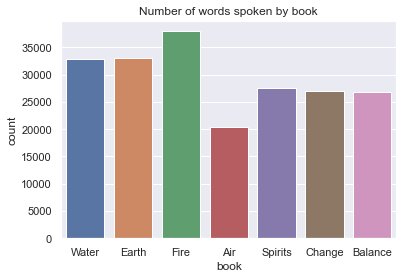

In [114]:
dialogue = transcript_df[['book', 'dialogue']]

num_tokens = []
for book_name in transcript_df['book'].unique():
    book_dialogue = transcript_df[transcript_df['book'].str.contains(book_name[0])]
    book_text = ' '.join(book_dialogue['dialogue'])
    
    # Extract tokens (also removes punctuation)
    tokenizer = nltk.RegexpTokenizer(r'[\w\']+')
    tokens = tokenizer.tokenize(book_text)
    
    # Convert to lower case
    tokens = [token.lower() for token in tokens]
    num_tokens.append(len(tokens))

sns.barplot(y=num_tokens, x=list(transcript_df['book'].unique()))

plt.title('Number of words spoken by book')
plt.ylabel('count')
plt.xlabel('book')
plt.show()



We find that the above results are consistent with the episode counts found previously. It makes sense that a higher episode count results in a higher amount of dialogue.
Arguably, the above is a trivial observation. Let us normalize the token count by the number of episodes to get a more telling result.

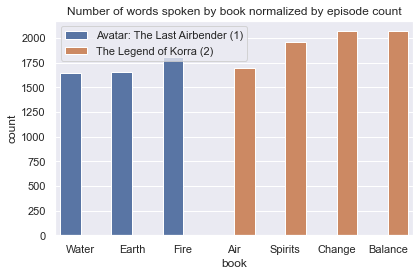

In [115]:
num_tokens_normalized = []
for book_name, token_count in zip(transcript_df['book'].unique(), num_tokens):
    episode_count = len(episode_info_df[episode_info_df.book == book_name])
    token_count_normalized = token_count / episode_count
    num_tokens_normalized.append(token_count_normalized)

tk_norm_df = pd.DataFrame({'tokens_norm': num_tokens_normalized, 'series': [1, 1, 1, 2, 2, 2, 2], 'book': transcript_df['book'].unique()})

sns.barplot(y='tokens_norm', hue='series', x='book', data=tk_norm_df)
legend = plt.legend()
legend.get_texts()[0].set_text('Avatar: The Last Airbender (1)')
legend.get_texts()[1].set_text('The Legend of Korra (2)')
plt.title('Number of words spoken by book normalized by episode count')
plt.ylabel('count')
plt.xlabel('book')

plt.tight_layout()
plt.show()

The above plot is more meaningful. Clearly, *The Legend of Korra* contains more dialogue on average per episode when compared to *Avatar: The Last Airbender*. Each episode of *The Legend of Korra* appears to be more densely packed. It will be interesting to see the implications of this in the subsequent analysis. 

### Word frequency by season

Here we will determine the most common words in each book. There's a good chance that this will mostly include stop words, but it will be interesting to compare each book nonetheless.

In [121]:
from functools import reduce

dialogue = transcript_df[['book', 'dialogue']]

word_freqs = []
for book_name in transcript_df['book'].unique():
    book_dialogue = transcript_df[transcript_df['book'].str.contains(book_name[0])]
    book_text = ' '.join(book_dialogue['dialogue'])
    
    # Extract tokens (also removes punctuation)
    tokenizer = nltk.RegexpTokenizer(r'[\w\']+')
    tokens = tokenizer.tokenize(book_text)
    
    # Convert to lower case
    tokens = [token.lower() for token in tokens]
    
    word_freqs.append(nltk.FreqDist(tokens))
    
dfs = []
for word_freq, book_name in zip(word_freqs, transcript_df['book'].unique()):
    dist = word_freq.most_common(10)
    
    # Adding a suffix for each word count
    df = pd.DataFrame({'word': [word for (word, _) in dist], 'count_' + book_name: [str(count) for (_, count) in dist]})
    dfs.append(df)


# 7-way outer merge
reduce(lambda left, right: pd.merge(left, right, on='word', how='outer'), dfs)

,word,count_Water,count_Earth,count_Fire,count_Air,count_Spirits,count_Change,count_Balance
0,the,1225,1285,1367,823,1166,928,931
1,you,1197,1171,1388,653,1001,908,975
2,to,920,979,1009,558,819,836,882
3,i,916,864,1342,539,825,803,907
4,a,620,600,673,370,416,489,419
5,and,414,487,640,323,429,468,494
6,it,398,423,505,NaN,261,NaN,249
7,of,388,472,439,271,363,369,353
8,is,358,405,382,239,322,267,NaN
9,that,340,NaN,NaN,NaN,NaN,NaN,251


The above table shows the top 10 most common words for each book. Note that the table actually has 13 rows, since not all books has the same words in their top 10. `NaN` values indicate words that are not part of that book's top 10. The number of rows is actually interesting, since it is close to 10. This means that each book generally has the same words in common. As expected, the distribution almost exclusively contains stop words, since these were not filtered up.

### Most connected characters (total degree)
We'll now be taking a look at some descriptive statistics of the network. Firstly, we would like to examine the most connected characters, and see if they are what we expect.

In [ ]:
degree_list = sorted(GCC.degree(), reverse=True, key=lambda pair: pair[1])
for idx, (name, links) in enumerate(degree_list[:10]):
    print(str(idx + 1) + '.', name, 'with', links, 'links')


1. Aang with 349 links
2. Katara with 287 links
3. Sokka with 284 links
4. Zuko with 240 links
5. Toph Beifong with 208 links
6. Korra with 202 links
7. Tenzin with 155 links
8. Bolin with 147 links
9. Mako with 140 links
10. Iroh with 137 links


There are close to no surprises here in terms of total degree. The top 5 includes the most well known characters of the series, the core part of the original *Team Avatar*: *Aang*, *Katara*, *Sokka*, *Zuko* and *Toph*. Interestingly, Aang, the main character of the first series is not so far ahead in terms of links of the supporting cast. 

*Korra*, the main character of the second series *The Legend of Korra*, lands at 6th place with $202$ links. It appears the she interacted with less characters overall. This perhaps give us a clue of the differences between the two series. The remaining characters are also mainly associated (expect *Iroh*) with the second series, reinforcing this point. We also know from earlier that *The Legend of Korra* contains less episodes, so this could be a reasonable explanation.

We also wish to explore the in-degrees and out-degree separately to see if this will shed further light on the situation.

In [16]:
out_deg = [G.out_degree(node_name) for node_name in G.nodes]
in_deg = [G.in_degree(node_name) for node_name in G.nodes]
in_out_deg = [x + y for x, y in zip(out_deg, in_deg)]

### Most connected characters (in-degree)

In [47]:
in_degree_list = sorted(GCC.in_degree(), reverse=True, key=lambda pair: pair[1])
for idx, (name, links) in enumerate(in_degree_list[:10]):
    print(str(idx + 1) + '.', name, 'with', links, 'in-links')

1. Aang with 266 in-links
2. Sokka with 205 in-links
3. Katara with 201 in-links
4. Zuko with 167 in-links
5. Korra with 139 in-links
6. Toph Beifong with 136 in-links
7. Iroh with 91 in-links
8. Tenzin with 91 in-links
9. Bolin with 89 in-links
10. Appa with 84 in-links


The in-degree tells the same story. Characters only move a place or two. It is interesting to see that *Appa* is the character with the 10th largest in-degree with $84$ links! 
Appa is a flying bison (i.e. non-human) that cannot talk. He is used as the primary means of transporation in the first series. It is amusing that a character which cannot even directly communicate with other characters has such a large in-degree.

### Most connected characters (out degree)

In [48]:
out_degree_list = sorted(GCC.out_degree(), reverse=True, key=lambda pair: pair[1])
for idx, (name, links) in enumerate(out_degree_list[:10]):
    print(str(idx + 1) + '.', name, 'with', links, 'out-links')

1. Katara with 86 out-links
2. Aang with 83 out-links
3. Sokka with 79 out-links
4. Zuko with 73 out-links
5. Toph Beifong with 72 out-links
6. Tenzin with 64 out-links
7. Korra with 63 out-links
8. Lin Beifong with 63 out-links
9. Jinora with 60 out-links
10. Bolin with 58 out-links


There is a single interesting aspect here. Both *Aaag* and *Korra* (main characters) are outdone by major characters in their respective series. This is *Katara* and *Tenzin* respectively.

### Average shortest path length

In [31]:
nx.average_shortest_path_length(GCC)

2.483110578547946

### Clustering coefficient

In [32]:
nx.average_clustering(GCC)

0.5789145460468168

### In-degree distribution

It is crucial we examine the degree distribution of our network to determine its characteristics. We expect our network to obey power laws, since we are dealing with a social network. However, it will be interesting to see if any individual degrees follow a poisson distribution.

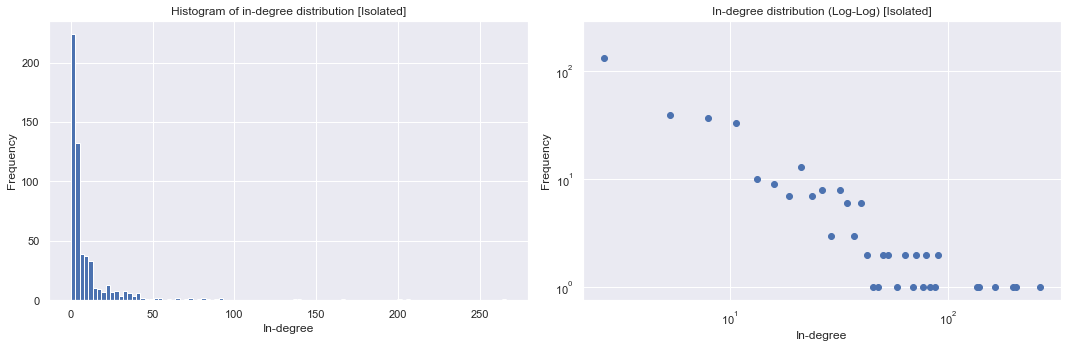

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

hist, bins = np.histogram(in_deg, bins=100)
axes[0].hist(bins[:-1], bins, weights=hist)
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('In-degree')
axes[0].set_title('Histogram of in-degree distribution [Isolated]')

axes[1].plot(bins[:-1], hist, 'bo')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_ylabel('Frequency')
axes[1].set_xlabel('In-degree')
axes[1].set_title('In-degree distribution (Log-Log) [Isolated]')

plt.tight_layout()
plt.show()

The above is in line with what we expect. We see that the number of degrees is highly disproportinate between chararcters, with most characters having close to 0 degree. There are also a few characters with an extremely high degree. The log-log plot shows a straight line, indicating that the in-degree follows a power law and likely is a scale-free network.


### Out-degree distribution

We now examine the out-degree distribution as before.

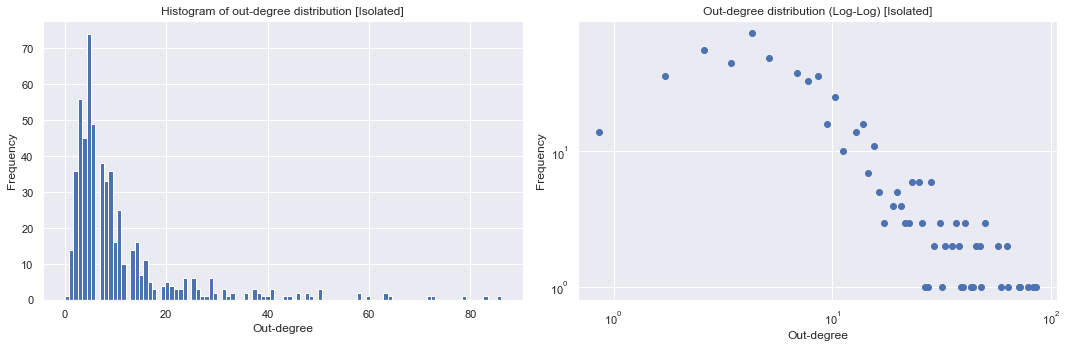

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

hist, bins = np.histogram(out_deg, bins=100)
axes[0].hist(bins[:-1], bins, weights=hist)
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Out-degree')
axes[0].set_title('Histogram of out-degree distribution [Isolated]')

axes[1].plot(bins[:-1], hist, 'bo')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_ylabel('Frequency')
axes[1].set_xlabel('Out-degree')
axes[1].set_title('Out-degree distribution (Log-Log) [Isolated]')

plt.tight_layout()
plt.show()

The out-degree is not as clear cut as the in-degree. The log-log plot is not completely straight, but instead has a kind of parabola shape. However, it looks like the vast majority of nodes are still present on the straight line to the right. The histogram also shows that the distribution is not quite as uneven as for the in-degree.

### Total degree distribution

For further clarity, we also look at the total degree below.

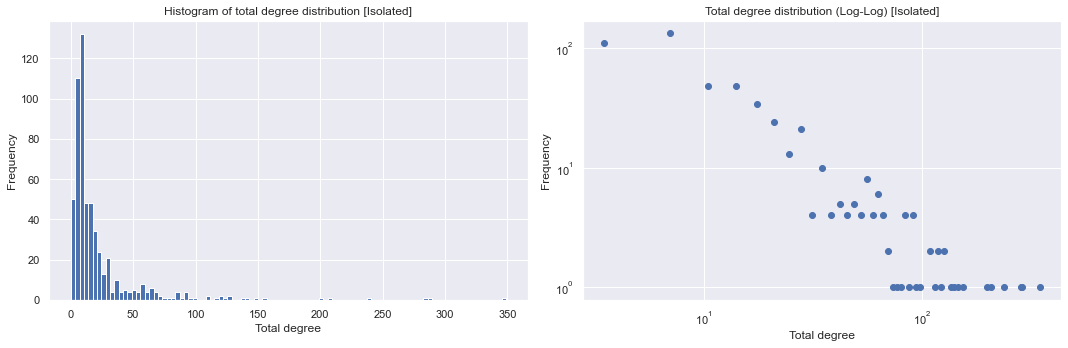

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

hist, bins = np.histogram(in_out_deg, bins=100)
axes[0].hist(bins[:-1], bins, weights=hist)
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Total degree')
axes[0].set_title('Histogram of total degree distribution [Isolated]')

axes[1].plot(bins[:-1], hist, 'bo')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_ylabel('Frequency')
axes[1].set_xlabel('Total degree')
axes[1].set_title('Total degree distribution (Log-Log) [Isolated]')

plt.tight_layout()
plt.show()

The total degree is more akin to the in-degree plots. This is expected, since the in-degree is much higher than the out degree. Based on the three degree distributions, it would not be far fetched to consider the network scale-free. It is characterized by an extremely disproportiate degree distribution, with a few nodes serving as hubs with massive degrees.

### Exponent of degree distributions

Even given the above, we wish to further reinforce our point. Therefore, we will examine $\alpha$, the degree exponent. If our network truly is scale-free, we expect that $2 \lt \alpha \lt 3$. 

In [30]:
in_deg_exponent = powerlaw.Fit(in_deg, verbose=False).alpha
out_deg_exponent = powerlaw.Fit(out_deg, verbose=False).alpha

print('In-degree exponent:', in_deg_exponent)
print('Out-degree exponent:', out_deg_exponent)

In-degree exponent: 2.7162278098536237
Out-degree exponent: 2.521860184562475


The in-degree exponent is $\alpha_{in} = 2.72$ and the out-degree exponent is $\alpha_{out} = 2.52$. This confirms that our network is scale-free, by being in the *ultra-small world* regime. This is exactly because it holds that $2 \lt \alpha_{in} \lt 3$ and $2 \lt \alpha_{out} \lt 3$. We can also certainly say that our network is **not** a random network.

### Attribute distributions

This section will briefly look at the distributions of character attributes.

#### Distribution of nationalities

We know that nationality is important in ATLA, but what is the representation of each nationality? Some nationalities are naturally smaller in terms of population, meaning that they will appear underrepresented.

In [31]:
nationalities = [attribs['nationality'] for _, attribs in G.nodes(data=True)]

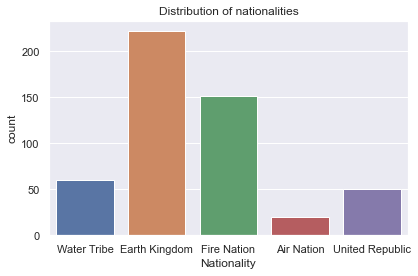

In [33]:
sns.countplot(x=nationalities)

plt.xlabel('Nationality')
plt.title('Distribution of nationalities')

plt.tight_layout()
plt.show()

We see that the Earth Kingdom is by far the most represented nation, but the Fire Nation following behind in second. It makes sense that the Water Tribe and Air Nation are small, since they are much closer to tribes found in the real world. We cannot actually say that the Earth Kingdom has a larger population than the Fire Nation from the above. What we can say however, is that the main characters of both series interact with characters from the Earth Kingdom to a greater degree.

#### Distribution of gender

ATLA has been praised for inclusion and handling of social issues in the past. It will be interesting to see if the gender representation will be close to 50-50 or something else entirely.

In [35]:
genders = [attribs['gender'] for _, attribs in G.nodes(data=True)]

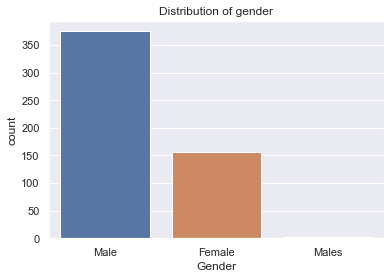

In [36]:
sns.countplot(x=genders)

plt.title('Distribution of gender')
plt.xlabel('Gender')
plt.show()

This result is a bit surprising. It appears that male characters far outweigh the female characters by a factor of more than 2. Determining why this is the case is difficult. In the end, it comes up to how the writers determined to frame the show.

#### Distribution of bending styles
Here we will most likely see results similar to that of the nationality distribution. However, here we will also be also to gauge the number of non-benders in the ATLA universe.

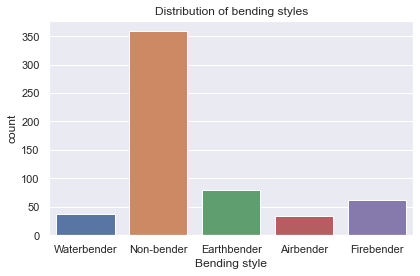

In [37]:
benders = [attribs['bending_art'] for _, attribs in G.nodes(data=True)]

sns.countplot(x=benders)

plt.xlabel('Bending style')
plt.title('Distribution of bending styles')

plt.tight_layout()
plt.show()

As we can see, the *vast* majority of characters are non-benders. This gives us an interesting aspect of the series. Mastering a bending art is rare, and most common folk will never master it. It is also expected that this plot is similar to the distribution of nationalities. Characters from the Earth Kingdom are typically earthebenders and so on.

### Visualizing the network

In this part we will finally be visualizing the network. We hope display the network such that meaningful information can be extracted. For this part, we will be using the undirected version of the GCC.

We'll be using `ForceAtlas2` for finding node positions.

In [38]:
GCC_undirected = GCC.to_undirected()

We wish to color each node according to the `nationality` attribute. The Earth Kingdom is green, Fire Nation is red, Water Tribe is blue and Air Nation is grey, United Republic is purple and nodes without a nation are black.

In [95]:
color_map = []
for node, attribs in GCC_undirected.nodes(data=True):
    if attribs['nationality'] == 'Earth Kingdom':
        color_map.append('#5F974E')
    elif attribs['nationality'] == 'Fire Nation':
        color_map.append('#e64358')
    elif attribs['nationality'] == 'Water Tribe':
        color_map.append('#2E67A0')
    elif attribs['nationality'] == 'Air Nation':
        color_map.append('#bee5fd')
    elif attribs['nationality'] == 'United Republic':
        color_map.append('purple')
    else:
        color_map.append('black')

We also want the size of nodes to be exponentially correlated with degree. This will help visualize hubs in the network. Naturally, the exponent will be small to avoid explosive node growth. In this case, we have chosen $1.3$. 

In [64]:
degree_dict = dict(GCC_undirected.degree)
node_sizes = [n ** 1.3 for n in degree_dict.values()]

It is helpful to have node labels for hubs to recognize key characters. We say that if $d \ge 100$, that node's label is shown.

In [91]:
labels = {}

for n in GCC_undirected.nodes():
    label = n

    # Make Toph's name a bit smaller to make it fit on the plot
    if str(label) == 'Toph Beifong':
        label = 'Toph'

    if GCC_undirected.degree[n] >= 100:
        labels[n] = label
    else:
        labels[n] = ''

Edges are also colored. If characters of the same nationality are connected, the edge is colored with the nationality color described above.

In [105]:
edge_colors = []

for n1, n2 in GCC_undirected.edges():
    n1_nat = GCC.nodes[n1]['nationality']
    n2_nat = GCC.nodes[n2]['nationality']
    
    if n1_nat == n2_nat:

        if n1_nat == 'Water Tribe':
            edge_colors.append('#2E67A0')
        elif n1_nat == 'Earth Kingdom':
            edge_colors.append('#5F974E')
        elif n1_nat == 'Fire Nation':
            edge_colors.append('#e64358')
        elif n1_nat == 'Air Nation':
            edge_colors.append('#bee5fd')
        elif n1_nat == 'United Republic':
            edge_colors.append('purple')
    else:
        edge_colors.append('black')

Finally, we can combine the above and visualize the network.

In [110]:
fa2_object =  ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=0.5,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=2,

                        # Log
                        verbose=False)


positions = fa2_object.forceatlas2_networkx_layout(GCC_undirected, pos=None, iterations=2000)

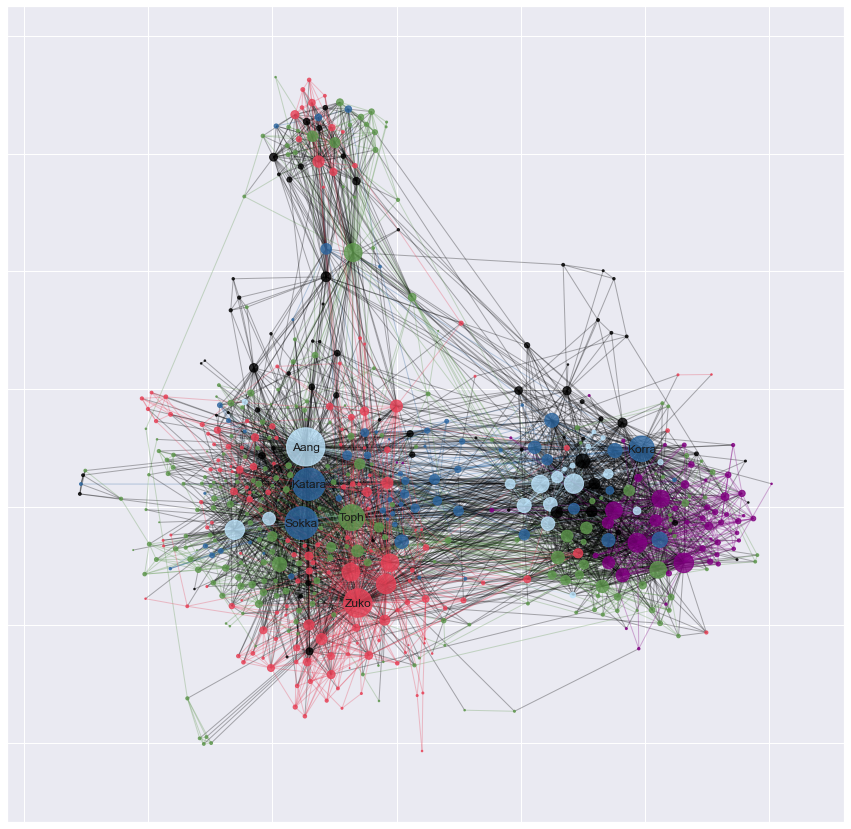

In [111]:
plt.figure(3, figsize=(15,15))
nx.draw_networkx_nodes(GCC_undirected, positions, node_color=color_map, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(GCC_undirected, positions, edge_color=edge_colors, alpha=0.3)
nx.draw_networkx_labels(GCC_undirected, positions, labels, font_size=12)
plt.show()

What first comes to mind from the above visualization is how extremely connected the network is. There is a large number of edges all around, making it difficult to discern individual edges. There are also very few "lines" of connected nodes of low degree. This indicates that the entire cast of ATLA are well connected.

The hub structure of a scale-free network is easily present. We have six hubs, consisting of the characters *Aang*, *Sokka*, *Katara*, *Toph*, *Zuko* and *Korra*. These are the most prevalent characters of both series, making their hub status expected.

There appears to be three clusters in total. One to left, one to the right and a smaller one at the top. It is in particular the two larger clusters that are interesting. It seems that these two clusters effectively separate characters from each series. There are several reasons for this. Firstly, *Korra* is the main character of *The Legend of Korra* and belongs in her own cluster, with the remaining hubs residing in the other cluster. The clusters also contain a high density of edges, which is expected since they would interact frequently if within the same series. We also exclusively see *United Republic* characters in *Korra*'s cluster, since this nation was not introduced until the second series. There is also a degree of interconnectivity between the two clusters, since both series are in the same universe and time period.

## Tools, theory and analysis

### Word clouds and communities

In the ATLA universe, there is a strong emphasis on nationality. The conflicts within the series are based on the constrasting interests between nations. For example, the Fire Nation has in recent years been known to be especially millitant and aggressive, so it will be interesting to see if these beliefs will be confirmed. On the other hand, the Air Nation is known to consist of peaceful monks.

Our tool of choice for this task is *word clouds*. Word clouds are visual collections of words from text documents, where the size of the word indicates their importance according to some metric. 

We'll first be cleaning the character pages. We are using the plain text character pages for this purpose, to avoid any additional cleaning. The cleaning process involves removing wiki headers and other character names. Whilst tokenizing the text, we are also removing stop words, lemmatizing and removing capital letters.

This whole process takes over an hour usually. Therefore, we are saving the cleaned text as text files in case of kernel restarts.

In [113]:
def clean_text(name,df):
    if name == "Dock/Xu/Bushi": #Special case for name
        name = "Dock-Xu-Bushi"
    path = 'characters_cleaned_text/'
    if not os.path.exists(path):
        os.makedirs(path)
    #print("Cleaning name: ",name)
    with open('characters_plain_text/' + name + '.txt', "r+") as f:
        text = f.read() # Read content of file
        text = re.sub('\=+[\w\s]+\=+',"",text) # Remove headers with format  = header = ,== header ==,etc
        
    for char in df.name:
        text = re.sub(char,"",text) # Remove all names from content
        
    tokens = word_tokenize(text) # Tokenize the text
    clean_text = [word for word in tokens if not word in stopwords.words() and word.isalpha() and len(word)>1] # Clean from stopwords and making sure that its not a special character
    clean_lemmas_text = [WordNetLemmatizer().lemmatize(token) for token in clean_text] # Lematize words
    final_clean_text = [word.lower() for word in clean_lemmas_text] # Remove capital letters

    with open('characters_cleaned_text/' + name + '.txt', "w") as f:
        for token in final_clean_text:
            f.write(token + "\n") # Save tokens 
        f.close()
            
for name in data.name:
    clean_text(name,data)

Next, we will for every nationality join the text into a corpus.

In [114]:
nat_dict = {}
words = []
for nat in data.nationality.unique():
    nat_text = []
    for name in data[data["nationality"] == nat].name:
        if name == "Dock/Xu/Bushi":
            name = "Dock-Xu-Bushi"
        with open ('characters_cleaned_text/' + name + '.txt', "r") as f:
            text = f.read()
            tokens = text.split("\n")
            tokens = list(filter(None, tokens)) #Remove empty space as token
            nat_text.extend(tokens)
    nat_dict[nat] = nat_text
    words.extend(nat_text)
    
vocab = sorted(list(set(words)))

The following code block defines helper functions used for calculating various term frequency statistics. Please refer to the individual functions for a short explanation of each.

In [115]:
def get_tf(doc):
    """Get TF of a document. 

    Returns a dictionary. 
    """ 
    tf_dict = {}
    counts = Counter(doc)
    for item in counts.keys():
        tf_dict[item] = counts[item] / len(doc)
    return tf_dict

def get_tc(doc):
    """Get TC of a document. 

    Returns a dictionary. 
    """
    tc_dict = {}
    counts = Counter(doc)
    tc_dict = dict(counts)
    return tc_dict

def get_idf(nat_dict,vocab):
    """Get IDF from a number of documents. 

    Returns a dictionary. 
    """
    idf_dict = {}
    D = len(nat_dict)
    for word in vocab:
        counter = 0
        for nat in nat_dict:
            if word in nat_dict[nat]:
                counter += 1
        idf_dict[word] = math.log((D/counter),10)
    return idf_dict

def get_tc_idf(tc_dict,idf_dict,nat_dict):
    """Get TC-IDF of a document. 

    Returns a dictionary. 
    """
    tc_idf = {}
    for nat in nat_dict:
        tc_idf[nat] = {}
        for word in nat_dict[nat]:
            tc_idf[nat][word] = tc_dict[nat][word] * idf_dict[word]
    return tc_idf

def get_tf_idf(tf_dict,idf_dict,nat_dict):
    """Get TF-IDF of a document. 

    Returns a dictionary. 
    """
    tf_idf = {}
    for nat in nat_dict:
        tf_idf[nat] = {}
        for word in nat_dict[nat]:
            tf_idf[nat][word] = tf_dict[nat][word] * idf_dict[word]
    return tf_idf


def get_score_by_tc(doc,nat,tc_dict,idf_dict):
    """Get Scores of words in a document based on rounding TC-IDF values. 

    Returns a dictionary.
    """
    score = {}
    for word in doc:
        score[word] = math.ceil(tc_dict[nat][word] * idf_dict[word])
    return score

def get_score_by_tf(doc,nat,tf_dict,idf_dict):
    """Get Scores of words in a document based on rounding TF-IDF values. 

    Returns a dictionary.
    """
    score = {}
    for word in doc:
        score[word] = math.ceil(tf_dict[nat][word] * idf_dict[word])
    return score
        
def get_top_words(data, n):
    """Get top n words by value (score) . 

    Returns a dictionary.
    """ 
    top = sorted(data.items(), key=lambda x: x[1], reverse=True)[:n]
    return dict(top)

tc = {}
tf = {}
idf = {}


Here we are calculating the IDF, TC-IDF and TF-IDF for each corpus containing text related to a nationality.

In [116]:
for nat in nat_dict:
    tc[nat] = get_tc(nat_dict[nat])
    tf[nat] = get_tf(nat_dict[nat])

idf = get_idf(nat_dict,vocab)
tc_idf = get_tc_idf(tc,idf,nat_dict)
tf_idf = get_tf_idf(tf,idf,nat_dict)

scores = {}
top_words = {}
for nat in nat_dict:
    scores[nat] = get_score_by_tc(nat_dict[nat],nat,tc,idf)
    top_words[nat] = get_top_words(scores[nat],n=len(scores[nat]))

With the above done, we can display word clouds for each nationality. We decided on using TF-IDF to measure the importance of invidiual words, as this gave us the best results.

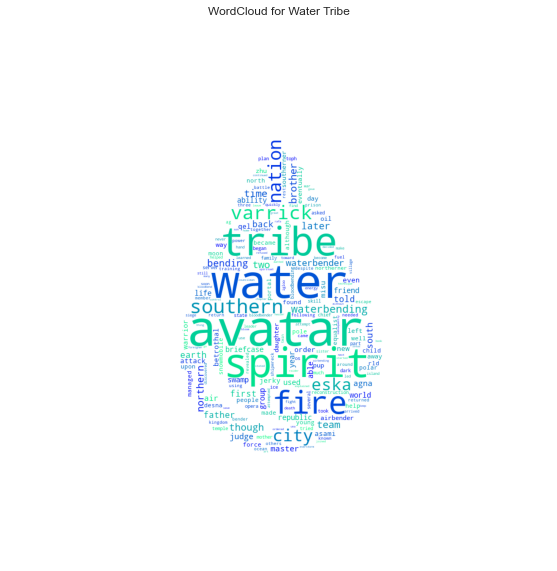

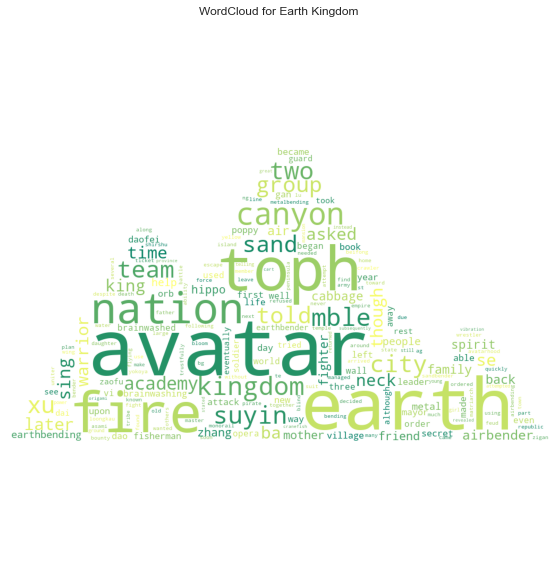

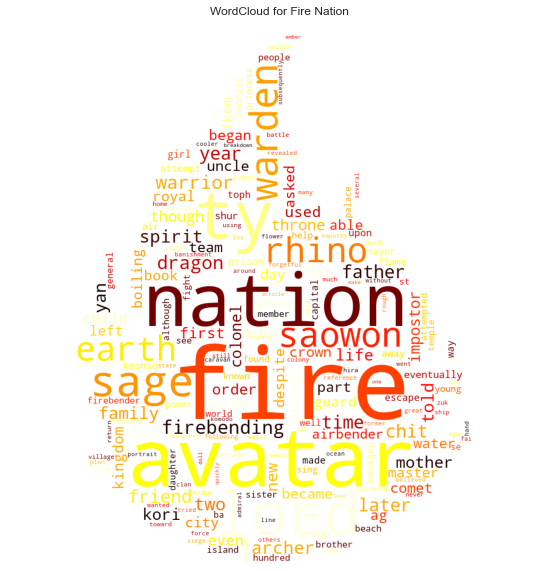

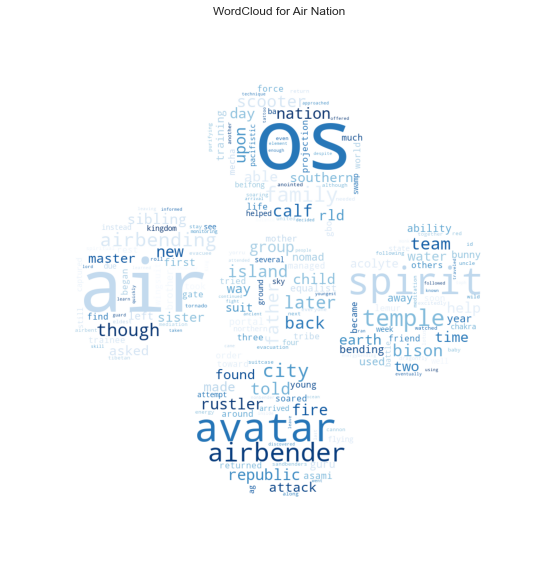

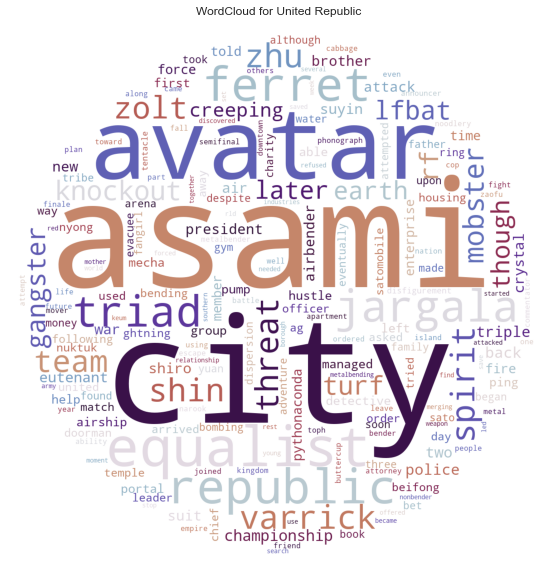

In [161]:
import PIL as PIL
colormap = ['winter','summer','hot','Blues', 'twilight']    
nat_list = list(data.nationality.unique())

def create_wordcloud(nat,color,scores):
    rep_words = ''
    word_string = ''
    nat_image = PIL.Image.open('word_logos/'+str(nat)+'.jpg')
    nat_image_array = np.array(nat_image)
    for i,word in enumerate(scores[nat]):
        for n in range(scores[nat][word]):
            rep_words = rep_words + word + ' '
    word_string = word_string + rep_words + ' '
    wordcloud = WordCloud(width=800, height=400, background_color = "white",colormap=color,collocations = False,mask=nat_image_array).generate(word_string)
    plt.figure(figsize=(20,10))
    img=plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("WordCloud for " +  nat)
    plt.show()
    
    
for nat,color in zip(nat_list,colormap):
    create_wordcloud(nat,color,scores)

In [118]:
avatar_graph = GCC_undirected

In [119]:
from community import community_louvain
def find_communities_from(graph):
    '''
    Finding the communities, plotting them and printing the count.
    '''
    partition = community_louvain.best_partition(graph,random_state=33)
    count = len(set(partition.values()))
    
    print(f'No. of found communities: {count}')
    
    return partition

def set_community_attribute(graph, attributes):
    '''
    Function for setting the community attribute to the character node.
    '''
    for char in graph.nodes():
        graph.nodes[char]['community'] = attributes[char]

    return graph


def plot_community_distribution(communities):
    '''
    Plot the distribution of the communities in chosen universe.
    '''

    data = [value for _, value in communities.items()]
    title = 'The communities size distribution'
    caption = 'The histogram is representing the number of members\nassigned to each community.'
    values, bins = np.histogram(data, range(len(set(communities.values()))+1))
    plt.bar(bins[:-1], values, width=0.5)
    plt.title(title)
    plt.xlabel('Community number')
    plt.ylabel('Count')
    plt.xticks(range(len(set(communities.values()))))
    plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.tight_layout()
    plt.show()
    


In [120]:
avatar_communities = find_communities_from(avatar_graph)

No. of found communities: 7


In [121]:
modularity = community_louvain.modularity(avatar_communities,avatar_graph)
print("Modularity of the communities partition using the Louvain algorithm is: ", modularity)

Modularity of the communities partition using the Louvain algorithm is:  0.48637757471575704


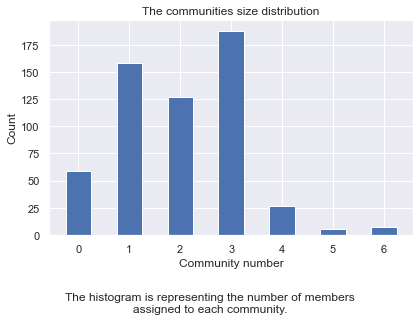

In [122]:
avatar_graph = set_community_attribute(avatar_graph,avatar_communities)
plot_community_distribution(avatar_communities)

In [123]:
def get_biggest_communities(communities, amount):
    '''
    Return the nodes for given amount of biggest communities.
    '''

    data = [value for _, value in communities.items()]
    vector = list(range(np.min(data), np.max(data) + 2))
    graph_values, _ = np.histogram(data, bins=vector)
    biggest_communities = np.argsort(-graph_values)[:amount]

    return {k: v for k, v in communities.items() if v in biggest_communities}

def invert_dict(d):
    '''
    Helper function for inverting the dict structure. 
    '''
    inverse = {}
    for key, item in d.items():
        if item not in inverse:
            inverse[item] = [key]
        else:
            inverse[item].append(key)
    return inverse



biggest_communities = get_biggest_communities(avatar_communities, 6)
inverted_biggest_communities = invert_dict(biggest_communities)
inverted_all_communities = invert_dict(avatar_communities)


In [124]:

comm_dict = {}
comm_words = []
for comm in inverted_all_communities:
    comm_text = []
    for name in inverted_all_communities[comm]:
        if name == "Dock/Xu/Bushi":
            name = "Dock-Xu-Bushi"
        with open ('characters_cleaned_text/' + name + '.txt', "r") as f:
            text = f.read()
            tokens = text.split("\n")
            tokens = list(filter(None, tokens)) #Remove empty space as token
            comm_text.extend(tokens)

    comm_dict[comm] = comm_text
    comm_words.extend(comm_text)
    
comm_vocab = sorted(list(set(comm_words)))

comm_tf = {}
comm_tc = {}
comm_idf = {}

for comm in inverted_all_communities:
    comm_tf[comm] = get_tf(comm_dict[comm])
    comm_tc[comm] = get_tc(comm_dict[comm])
comm_idf = get_idf(comm_dict,comm_vocab)

comm_tc_idf = get_tc_idf(comm_tc,comm_idf,comm_dict)
comm_tf_idf = get_tf_idf(comm_tf,comm_idf,comm_dict)

top_5_tf = {}
top_5_tf_idf = {}

for comm in inverted_biggest_communities:
    top_5_tf[comm] = get_top_words(comm_tf[comm],5)
    top_5_tf_idf[comm] = get_top_words(comm_tf_idf[comm],5)

In [125]:
for comm in inverted_biggest_communities:
    print("Top 5 terms according to TF for community", comm, "are: \n" )
    for k,v in top_5_tf[comm].items():
        print(k,v)
    print()

Top 5 terms according to TF for community 0 are: 

avatar 0.017142707130106058
the 0.008164443977738108
fire 0.0072718681087892475
would 0.0068518324057544894
earth 0.005486716370891526

Top 5 terms according to TF for community 1 are: 

spirit 0.010193882346711149
avatar 0.008777329864765574
would 0.007009948964394225
city 0.006983471347909261
the 0.006374486168755088

Top 5 terms according to TF for community 2 are: 

fire 0.016837005966798605
the 0.011017900395817333
avatar 0.010929284574939446
nation 0.008950197908666628
he 0.0063951084066875405

Top 5 terms according to TF for community 3 are: 

avatar 0.01460230883287439
the 0.01405952128786274
fire 0.011583880533785215
toph 0.008764033043846643
nation 0.007956471086634187

Top 5 terms according to TF for community 4 are: 

tribe 0.010682969000864517
southern 0.009447943682845497
toph 0.009447943682845497
water 0.008830431023835988
the 0.00821291836482648

Top 5 terms according to TF for community 6 are: 

fire 0.0395956192080876

In [126]:
for comm in inverted_biggest_communities:
    print("Top 5 terms according to TF-IDF for community", comm, " are: \n" )
    for k,v in top_5_tf_idf[comm].items():
        print(k,v)
    print()

Top 5 terms according to TF-IDF for community 0  are: 

saowon 0.001930156712203096
xu 0.0016568280254287506
ge 0.0016195567815037472
daofei 0.0012426210190715629
necks 0.0010205426294407174

Top 5 terms according to TF-IDF for community 1  are: 

varrick 0.003641723587248917
zhu 0.0025564787701578416
os 0.0017854319069903401
suyin 0.001515059544540234
spirit 0.0014896120032599671

Top 5 terms according to TF-IDF for community 2  are: 

ty 0.0016304282446443301
spirit 0.000751056838424216
father 0.0005136538147843776
princess 0.0004522773399668148
family 0.00043380007046915924

Top 5 terms according to TF-IDF for community 3  are: 

toph 0.0012806709333164788
fighters 0.0008391012629881019
canyon 0.0005929648925115919
city 0.0004817025111719082
gbo 0.0004810847241131784

Top 5 terms according to TF-IDF for community 4  are: 

southern 0.00138060945157283
toph 0.00138060945157283
metalbending 0.0010205376874563431
academy 0.0009454981516139649
south 0.0009113827098618029

Top 5 terms ac

In [127]:
def label_community_nodes(graph):
    '''
    Labelling the character nodes with the community name consisting of
    three characters with highest degree in the community.
    '''
    communities = [graph.nodes[char]['community'] for char in graph.nodes()]
    communities = set(communities)

    for community in communities:
        subgraph = [char for char in graph.nodes() if graph.nodes[char]['community'] == community]
        subgraph = graph.subgraph(subgraph)
        names = sorted(subgraph.degree, key=lambda x: x[1], reverse=True)[:3]
        names = '-'.join([name[0] for name in names])
        nx.set_node_attributes(subgraph, names, 'community_name')

    return graph

def calculate_characters_labMT_sentiment(graph,series):
    '''
    Calculating the sentiment for each of the character page and setting
    the value to the character node as an attribute.
    Here the sentiment is calculated for every word in every sentence of the characters dialog and then we take the average
    '''

    with open('Dialogs' + '_' + str(series) + '.json',encoding='utf-8') as json_file:
        dialog_dict = json.load(json_file)


    sentiment_url = 'https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0026752.s001&type=supplementary'
    sentiment_values = pd.read_csv(sentiment_url, skiprows=3, delimiter='\t')[
        ['word', 'happiness_average']]

    for char in graph.nodes():
        try:
            dialog = dialog_dict[char]['combined_dialog']
        except: ### if there is no dialog for the character continue to the next character name
            continue 
        
        text = ''
        for sentence in dialog:
            text = text + sentence + " "
        tokens = WordPunctTokenizer().tokenize(text) # Tokenize the text
        clean_text = [word for word in tokens if not word in stopwords.words() and word.isalpha() and len(word)>1] # Clean from stopwords and making sure that its not a special character
        clean_lemmas_text = [WordNetLemmatizer().lemmatize(token) for token in clean_text] # Lematize words
        final_clean_text = [word.lower() for word in clean_lemmas_text] # Remove capital letters

        text = FreqDist(final_clean_text)
        sentiment = pd.DataFrame.from_dict(text, orient='index').reset_index()
        sentiment.columns = ['word', 'count']
        sentiment = sentiment.merge(sentiment_values, on=['word'])
        if sentiment.empty:
            continue
        sentiment['mean'] = (sentiment['happiness_average'] * sentiment['count']).sum() / \
                            sentiment['count'].sum()
        graph.nodes[char]['labMT_sentiment'+ '_' + str(series)] = sentiment['mean'].mean()

    return graph


def calculate_characters_Vader_sentiment(graph,series):
    '''
    Calculating the sentiment for each of the character page and setting
    the value to the character node as an attribute with the Vader analyzer.
    Here the sentiment is calculated for every sentence of the characters dialog and then we take the average
    '''

    with open('Dialogs' + '_' + str(series) + '.json',encoding='utf-8') as json_file:
        dialog_dict = json.load(json_file)


    analyzer = SentimentIntensityAnalyzer()

    for char in graph.nodes():
        try:
            dialog = dialog_dict[char]['combined_dialog']
        except: ### if there is no dialog for the character continue to the next character name
            continue
        
        char_sent = []
        for sentence in dialog:
            char_sent.append(analyzer.polarity_scores(sentence)['compound'])
        
        avg_char_sent = mean(char_sent)
        graph.nodes[char]['Vader_sentiment'+ '_' + str(series)] = avg_char_sent

    return graph



In [128]:
avatar_graph = label_community_nodes(avatar_graph)

avatar_graph = calculate_characters_labMT_sentiment(avatar_graph,'atla')
avatar_graph = calculate_characters_Vader_sentiment(avatar_graph,'atla')

avatar_graph = calculate_characters_labMT_sentiment(avatar_graph,'lok')
avatar_graph = calculate_characters_Vader_sentiment(avatar_graph,'lok')

avatar_graph = calculate_characters_labMT_sentiment(avatar_graph,'both')
avatar_graph = calculate_characters_Vader_sentiment(avatar_graph,'both')


In [129]:
def plot_sentiment_distribution(graph,metric,series):
    '''
    Ploting the sentiment distribution amongst the characters' pages.
    '''
    sentiments = nx.get_node_attributes(graph, metric+'_sentiment'+ '_' + str(series))
    title = f'The sentiment values distribution for {series} series'
    caption = f'The histogram is representing the distribution\nof sentiment amongst the characters according to {metric}.'
    values, bins = np.histogram([value for value in sentiments.values() if value is not np.nan],
                                10)
    plt.bar(bins[:-1], values, width=0.08)
    plt.title(title)
    plt.xlabel('Bin')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.grid()
    plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

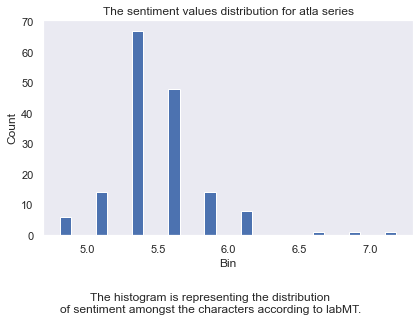

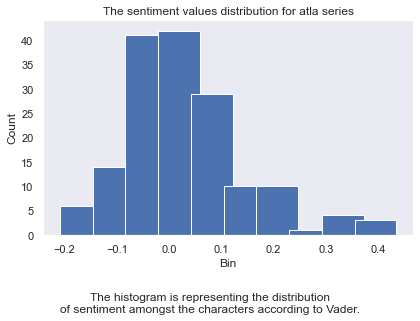

In [130]:
plot_sentiment_distribution(avatar_graph,'labMT','atla')
plot_sentiment_distribution(avatar_graph,'Vader','atla')

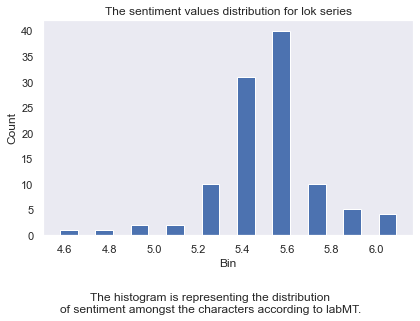

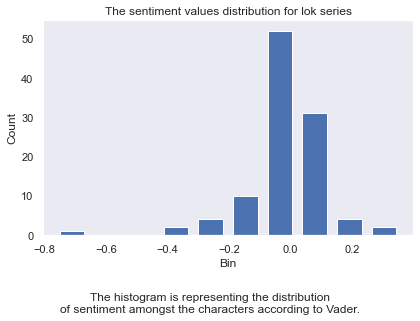

In [131]:
plot_sentiment_distribution(avatar_graph,'labMT','lok')
plot_sentiment_distribution(avatar_graph,'Vader','lok')

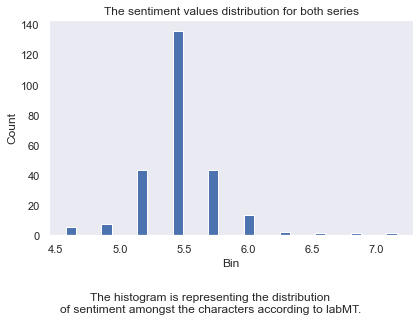

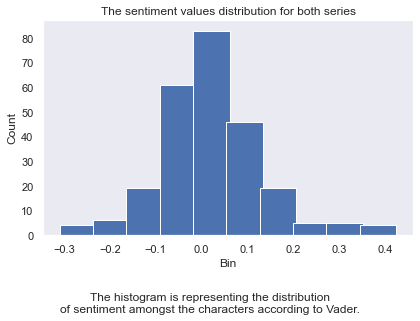

In [132]:
plot_sentiment_distribution(avatar_graph,'labMT','both')
plot_sentiment_distribution(avatar_graph,'Vader','both')

In [133]:
sentiments_df = pd.DataFrame.from_dict(dict(avatar_graph.nodes(data=True)), orient='index')
sentiments_df = sentiments_df.dropna(subset=['Vader_sentiment_atla','Vader_sentiment_lok','Vader_sentiment_both'])
sentiments_df = sentiments_df.dropna(subset=['labMT_sentiment_atla','labMT_sentiment_lok','labMT_sentiment_both'])
# sentiments_df = sentiments_df.drop(columns=['word_count']) # Dropping as word_count here does not reflect dialogs

#### Top 10 character sentiment using LabMT

In [134]:
sentiments_df.sort_values(by='labMT_sentiment_both', ascending=False).head(10)

,nationality,gender,bending_art,community,community_name,labMT_sentiment_lok,Vader_sentiment_lok,labMT_sentiment_both,Vader_sentiment_both,labMT_sentiment_atla,Vader_sentiment_atla
Wu,Earth Kingdom,Male,Non-bender,1,Korra-Bolin-Mako,5.747411,0.094981,5.729221,0.094607,5.612286,0.092265
Lily,Earth Kingdom,Female,Non-bender,3,Aang-Katara-Sokka,6.091429,0.000000,5.701923,0.001625,5.558421,0.002600
Iroh,Fire Nation,Male,Firebender,2,Zuko-Iroh-Azula,5.680980,0.116570,5.672455,0.111393,5.670499,0.110400
Kya,Water Tribe,Female,Waterbender,1,Korra-Bolin-Mako,5.613816,0.049643,5.611965,0.045752,5.592308,-0.000936
Aang,Air Nation,Male,Non-bender,3,Aang-Katara-Sokka,5.398205,-0.050690,5.602279,0.060881,5.603354,0.061285
Song,United Republic,Male,Earthbender,1,Korra-Bolin-Mako,5.348000,-0.066983,5.589792,-0.031450,5.634568,-0.021759
Wan Shi Tong,NaN,Male,Non-bender,3,Aang-Katara-Sokka,5.697532,0.065094,5.586667,-0.028506,5.522481,-0.081156
Katara,Water Tribe,Female,Waterbender,3,Aang-Katara-Sokka,5.691414,0.111543,5.579208,0.042438,5.575771,0.040728
Bumi,Air Nation,Male,Airbender,1,Korra-Bolin-Mako,5.563156,0.073666,5.565529,0.081571,5.571366,0.100980
Zuko,Fire Nation,Male,Firebender,2,Zuko-Iroh-Azula,5.587389,0.056658,5.564353,0.024060,5.563434,0.023155


#### Bottom 10 character sentiment using LabMT

In [135]:
sentiments_df.sort_values(by='labMT_sentiment_both', ascending=True).head(10)

,nationality,gender,bending_art,community,community_name,labMT_sentiment_lok,Vader_sentiment_lok,labMT_sentiment_both,Vader_sentiment_both,labMT_sentiment_atla,Vader_sentiment_atla
Engineer,United Republic,Male,Non-bender,1,Korra-Bolin-Mako,4.986667,-0.709950,5.258571,-0.221323,5.367333,-0.132482
Yung,Earth Kingdom,Male,Airbender,1,Korra-Bolin-Mako,5.713889,0.043717,5.499279,0.041333,5.396267,0.039382
Zhao,Fire Nation,Male,Firebender,2,Zuko-Iroh-Azula,5.503000,-0.040827,5.511549,-0.001515,5.511778,0.001267
Sokka,Water Tribe,Male,Non-bender,3,Aang-Katara-Sokka,5.544054,0.178740,5.545236,0.024653,5.545242,0.024359
Zuko,Fire Nation,Male,Firebender,2,Zuko-Iroh-Azula,5.587389,0.056658,5.564353,0.024060,5.563434,0.023155
Bumi,Air Nation,Male,Airbender,1,Korra-Bolin-Mako,5.563156,0.073666,5.565529,0.081571,5.571366,0.100980
Katara,Water Tribe,Female,Waterbender,3,Aang-Katara-Sokka,5.691414,0.111543,5.579208,0.042438,5.575771,0.040728
Wan Shi Tong,NaN,Male,Non-bender,3,Aang-Katara-Sokka,5.697532,0.065094,5.586667,-0.028506,5.522481,-0.081156
Song,United Republic,Male,Earthbender,1,Korra-Bolin-Mako,5.348000,-0.066983,5.589792,-0.031450,5.634568,-0.021759
Aang,Air Nation,Male,Non-bender,3,Aang-Katara-Sokka,5.398205,-0.050690,5.602279,0.060881,5.603354,0.061285


#### Top 10 character sentiment using Vader

In [136]:
sentiments_df.sort_values(by='Vader_sentiment_both', ascending=False).head(10)

,nationality,gender,bending_art,community,community_name,labMT_sentiment_lok,Vader_sentiment_lok,labMT_sentiment_both,Vader_sentiment_both,labMT_sentiment_atla,Vader_sentiment_atla
Iroh,Fire Nation,Male,Firebender,2,Zuko-Iroh-Azula,5.680980,0.116570,5.672455,0.111393,5.670499,0.110400
Wu,Earth Kingdom,Male,Non-bender,1,Korra-Bolin-Mako,5.747411,0.094981,5.729221,0.094607,5.612286,0.092265
Bumi,Air Nation,Male,Airbender,1,Korra-Bolin-Mako,5.563156,0.073666,5.565529,0.081571,5.571366,0.100980
Aang,Air Nation,Male,Non-bender,3,Aang-Katara-Sokka,5.398205,-0.050690,5.602279,0.060881,5.603354,0.061285
Kya,Water Tribe,Female,Waterbender,1,Korra-Bolin-Mako,5.613816,0.049643,5.611965,0.045752,5.592308,-0.000936
Katara,Water Tribe,Female,Waterbender,3,Aang-Katara-Sokka,5.691414,0.111543,5.579208,0.042438,5.575771,0.040728
Yung,Earth Kingdom,Male,Airbender,1,Korra-Bolin-Mako,5.713889,0.043717,5.499279,0.041333,5.396267,0.039382
Sokka,Water Tribe,Male,Non-bender,3,Aang-Katara-Sokka,5.544054,0.178740,5.545236,0.024653,5.545242,0.024359
Zuko,Fire Nation,Male,Firebender,2,Zuko-Iroh-Azula,5.587389,0.056658,5.564353,0.024060,5.563434,0.023155
Lily,Earth Kingdom,Female,Non-bender,3,Aang-Katara-Sokka,6.091429,0.000000,5.701923,0.001625,5.558421,0.002600


#### Bottom 10 character sentiment using Vader

In [137]:
sentiments_df.sort_values(by='Vader_sentiment_both', ascending=True).head(10)

,nationality,gender,bending_art,community,community_name,labMT_sentiment_lok,Vader_sentiment_lok,labMT_sentiment_both,Vader_sentiment_both,labMT_sentiment_atla,Vader_sentiment_atla
Engineer,United Republic,Male,Non-bender,1,Korra-Bolin-Mako,4.986667,-0.709950,5.258571,-0.221323,5.367333,-0.132482
Song,United Republic,Male,Earthbender,1,Korra-Bolin-Mako,5.348000,-0.066983,5.589792,-0.031450,5.634568,-0.021759
Wan Shi Tong,NaN,Male,Non-bender,3,Aang-Katara-Sokka,5.697532,0.065094,5.586667,-0.028506,5.522481,-0.081156
Zhao,Fire Nation,Male,Firebender,2,Zuko-Iroh-Azula,5.503000,-0.040827,5.511549,-0.001515,5.511778,0.001267
Lily,Earth Kingdom,Female,Non-bender,3,Aang-Katara-Sokka,6.091429,0.000000,5.701923,0.001625,5.558421,0.002600
Zuko,Fire Nation,Male,Firebender,2,Zuko-Iroh-Azula,5.587389,0.056658,5.564353,0.024060,5.563434,0.023155
Sokka,Water Tribe,Male,Non-bender,3,Aang-Katara-Sokka,5.544054,0.178740,5.545236,0.024653,5.545242,0.024359
Yung,Earth Kingdom,Male,Airbender,1,Korra-Bolin-Mako,5.713889,0.043717,5.499279,0.041333,5.396267,0.039382
Katara,Water Tribe,Female,Waterbender,3,Aang-Katara-Sokka,5.691414,0.111543,5.579208,0.042438,5.575771,0.040728
Kya,Water Tribe,Female,Waterbender,1,Korra-Bolin-Mako,5.613816,0.049643,5.611965,0.045752,5.592308,-0.000936


#### Sentiment per community

In [138]:
sentiments_df_agg = sentiments_df.groupby('community_name').mean()
sentiments_df_agg = sentiments_df_agg.drop(['community'], axis=1)

##### Happiest communities according to LabMT

In [139]:
hap_lab = sentiments_df_agg.sort_values(by='labMT_sentiment_both', ascending=False).head(3)
hap_lab[['labMT_sentiment_both']]

,labMT_sentiment_both
community_name,
Aang-Katara-Sokka,5.603062
Zuko-Iroh-Azula,5.582786
Korra-Bolin-Mako,5.542393


##### Happiest communities according to Vader

In [140]:
hap_vad = sentiments_df_agg.sort_values(by='Vader_sentiment_both', ascending=False).head(3)
hap_vad[['Vader_sentiment_both']]

,Vader_sentiment_both
community_name,
Zuko-Iroh-Azula,0.044646
Aang-Katara-Sokka,0.020218
Korra-Bolin-Mako,0.001748


##### Saddest communities according to LabMT

In [141]:
sad_lab = sentiments_df_agg.sort_values(by='labMT_sentiment_both', ascending=True).head(3)
sad_lab[['labMT_sentiment_both']]

,labMT_sentiment_both
community_name,
Korra-Bolin-Mako,5.542393
Zuko-Iroh-Azula,5.582786
Aang-Katara-Sokka,5.603062


##### Saddest communities according to Vader

In [142]:
sad_vad = sentiments_df_agg.sort_values(by='Vader_sentiment_both', ascending=True).head(3)
sad_vad[['Vader_sentiment_both']]

,Vader_sentiment_both
community_name,
Korra-Bolin-Mako,0.001748
Aang-Katara-Sokka,0.020218
Zuko-Iroh-Azula,0.044646


##### Plots with error bars per community for both LabMT and Vader

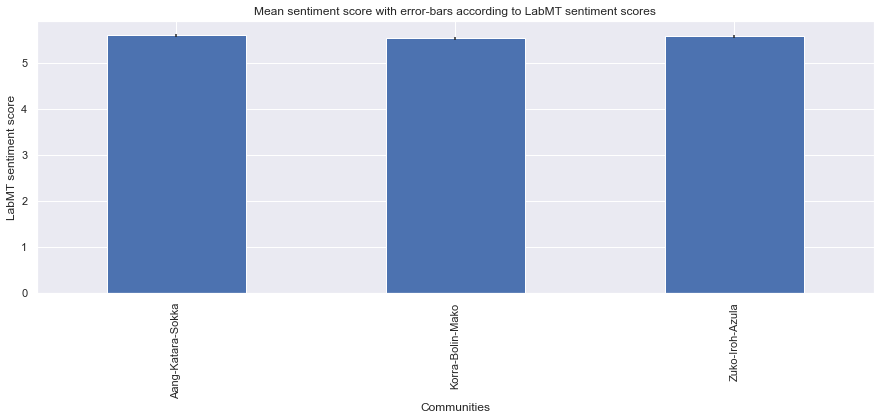

In [143]:
fig = sentiments_df_agg['labMT_sentiment_both'].plot(kind='bar',yerr=sentiments_df_agg.labMT_sentiment_both.std(),ylabel='LabMT sentiment score',xlabel='Communities',title='Mean sentiment score with error-bars according to LabMT sentiment scores',figsize=(15,5))

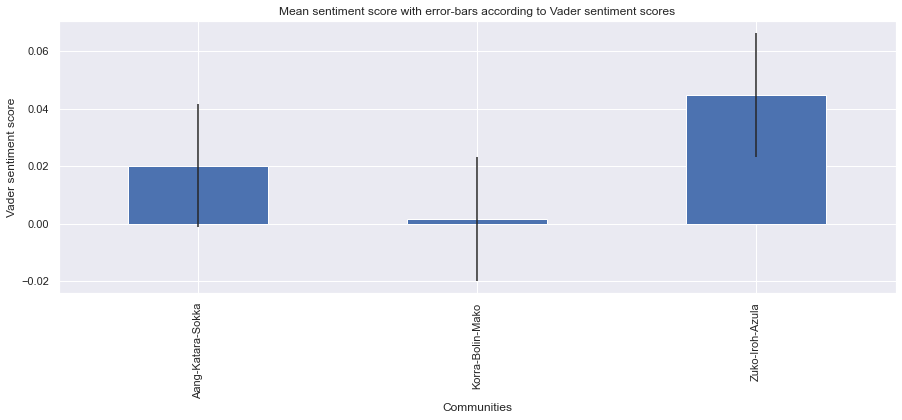

In [144]:
fig = sentiments_df_agg['Vader_sentiment_both'].plot(kind='bar',yerr=sentiments_df_agg.Vader_sentiment_both.std(),ylabel='Vader sentiment score',xlabel='Communities',title='Mean sentiment score with error-bars according to Vader sentiment scores',figsize=(15,5))

### Temporal sentiment analysis

#### Preprocessing dialogue

In [145]:
def calculate_episode_labMT_sentiment(episodes_df):
    '''
    Calculating the sentiment for each episode
    Here the sentiment is calculated for every word in every sentence of the characters dialog and then we take the average
    '''


    sentiment_url = 'https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0026752.s001&type=supplementary'
    sentiment_values = pd.read_csv(sentiment_url, skiprows=3, delimiter='\t')[['word', 'happiness_average']]

    for index,row in episodes_df.iterrows():
        dialog = row['Dialog']
       
        text = ''
        for sentence in dialog:
            text = text + sentence + " "
        tokens = WordPunctTokenizer().tokenize(text) # Tokenize the text
        clean_text = [word for word in tokens if not word in stopwords.words() and word.isalpha() and len(word)>1] # Clean from stopwords and making sure that its not a special character
        clean_lemmas_text = [WordNetLemmatizer().lemmatize(token) for token in clean_text] # Lematize words
        final_clean_text = [word.lower() for word in clean_lemmas_text] # Remove capital letters


        text = FreqDist(final_clean_text)
#         print(text)
        sentiment = pd.DataFrame.from_dict(text, orient='index').reset_index()
        sentiment.columns = ['word', 'count']
        sentiment = sentiment.merge(sentiment_values, on=['word'])
        if sentiment.empty:
            continue
        sentiment['mean'] = (sentiment['happiness_average'] * sentiment['count']).sum() / \
                            sentiment['count'].sum()
        
        episodes_df.loc[index,'labMT_sentiment'] = sentiment['mean'].mean()

    return episodes_df


def calculate_episode_Vader_sentiment(episodes_df):
    '''
    Calculating the sentiment for each of episode 
    Here the sentiment is calculated for every sentence of the characters dialog and then we take the average
    '''

    analyzer = SentimentIntensityAnalyzer()

    for index,row in episodes_df.iterrows():
        
        dialog = row['Dialog']
        episode_sent = []
        for sentence in dialog:
            episode_sent.append(analyzer.polarity_scores(sentence)['compound'])
        
        avg_episode_sent = mean(episode_sent)
        episodes_df.loc[index,'Vader_sentiment'] = avg_episode_sent

    return episodes_df

In [146]:
dialog_df = pd.read_csv("atla_lok_transcript.csv",index_col=0)
dialog_df['dialogue'] = dialog_df['dialogue'].astype(str)
dialog_df

,series,episode_name,book,book_number,episode_number,character_name,dialogue
0,1,The Boy in the Iceberg,Water,1,1,Sokka,It's not getting away from me this time. Watch...
1,1,The Boy in the Iceberg,Water,1,1,Katara,"Sokka, look!"
2,1,The Boy in the Iceberg,Water,1,1,Katara,"But, Sokka! I caught one!"
3,1,The Boy in the Iceberg,Water,1,1,Katara,Hey!
4,1,The Boy in the Iceberg,Water,1,1,Sokka,Why is it that every time ''you'' play with ma...
...,...,...,...,...,...,...,...
16753,2,The Last Stand,Balance,4,1,Korra,"So, what now? Back to the dance floor?"
16754,2,The Last Stand,Balance,4,1,Asami,"I'm kind of all danced out. Honestly, after ev..."
16755,2,The Last Stand,Balance,4,1,Korra,"Let's do it! Let's go on a vacation, just the ..."
16756,2,The Last Stand,Balance,4,1,Asami,Really? Okay ... I've always wanted to see wha...


In [147]:
dialog_df_groups = dialog_df.groupby(['series','episode_name','book','book_number','episode_number'])['dialogue'].apply(lambda x: ','.join(x)).reset_index()
dialog_df_groups.rename(columns={"dialogue": "Dialog"},inplace=True)
dialog_df_groups.set_index("episode_name",inplace=True)


def split_into_list(text):
    text = str(text)
    return nltk.tokenize.sent_tokenize(text)


dialog_df_groups['Dialog'] = dialog_df_groups['Dialog'].apply(lambda x: split_into_list(x))
dialog_df_groups

,series,book,book_number,episode_number,Dialog
episode_name,,,,,
Appa's Lost Days,1,Earth,2,1,"[No!, Stop sinking!,Don't make me put this dow..."
Avatar Day,1,Earth,2,1,"[What are you doing in my mouth?, Momo, you ne..."
Bato of the Water Tribe,1,Water,1,1,"[Hey, look!, A sword made out of a whale's too..."
Bitter Work,1,Earth,2,1,"[Today's the day!, Can you believe it?, After ..."
City of Walls and Secrets,1,Earth,2,1,"[Look, the Inner Wall!, I can't believe we fin..."
...,...,...,...,...,...
The Voice in the Night,2,Air,1,1,"[Benders be on alert., After coming face to fa..."
Turning the Tides,2,Air,1,1,"[Amon's revolution grows stronger by the day.,..."
Venom of the Red Lotus,2,Change,3,1,"[The Red Lotus has captured the Avatar., Korra..."


In [148]:
dialog_df_groups = calculate_episode_labMT_sentiment(dialog_df_groups)
dialog_df_groups = calculate_episode_Vader_sentiment(dialog_df_groups)
dialog_df_groups

,series,book,book_number,episode_number,Dialog,labMT_sentiment,Vader_sentiment
episode_name,,,,,,,
Appa's Lost Days,1,Earth,2,1,"[No!, Stop sinking!,Don't make me put this dow...",5.464156,0.049345
Avatar Day,1,Earth,2,1,"[What are you doing in my mouth?, Momo, you ne...",5.573531,0.022081
Bato of the Water Tribe,1,Water,1,1,"[Hey, look!, A sword made out of a whale's too...",5.615349,0.078005
Bitter Work,1,Earth,2,1,"[Today's the day!, Can you believe it?, After ...",5.692702,0.142751
City of Walls and Secrets,1,Earth,2,1,"[Look, the Inner Wall!, I can't believe we fin...",5.603258,-0.001174
...,...,...,...,...,...,...,...
The Voice in the Night,2,Air,1,1,"[Benders be on alert., After coming face to fa...",5.610448,0.108320
Turning the Tides,2,Air,1,1,"[Amon's revolution grows stronger by the day.,...",5.626127,0.090068
Venom of the Red Lotus,2,Change,3,1,"[The Red Lotus has captured the Avatar., Korra...",5.621931,0.115671


#### Sentiment per series

In [149]:
px.histogram(dialog_df_groups, x='labMT_sentiment',color='series', barmode='group')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'series=1<br>labMT_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': '1',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '1',
              'offsetgroup': '1',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([5.46415625, 5.57353075, 5.61534884, 5.69270244, 5.60325843, 5.5109898 ,
                          5.60995704, 5.54347884, 5.64596932, 5.5357524 , 5.59567251, 5.53088531,
                          5.63760331, 5.65379592, 5.58553165, 5.67347884, 5.51608063, 5.69821256,
                          5.60318402, 5.53644214, 5.45818664, 5.40740413, 5.6015756 , 5.66432946,
                          5.54659919, 5.5990458 , 5.53398003, 5.52919426, 5.57311688, 5.47802982,
                          5.4695057 , 5.56724976, 5.57879202, 5.54216942, 5.75964083, 5.51897919,
                          5.63370155, 5.63531453, 5.64841339, 5.59762231, 5.50383881, 5.64550679,
                          5.60248155, 5.6071831 , 5.6831104 , 5.61630499, 5.63774086, 5.63281395,
                          5.49923845, 5.553804  , 5.65491404, 5.79363002, 5.60939729, 5.73726027,
                          5.56660926, 5.51693676, 5.55870031, 5.42554913, 5.49993939]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'series=2<br>labMT_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': '2',
              'marker': {'color': '#EF553B', 'pattern': {'shape': ''}},
              'name': '2',
              'offsetgroup': '2',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([5.53176909, 5.61917007, 5.71877497, 5.74313131, 5.57480453, 5.5842314 ,
                          5.48657931, 5.54890792, 5.63333588, 5.69359091, 5.5069802 , 5.53925272,
                          5.52442543, 5.5275021 , 5.54151286, 5.57479651, 5.53279352, 5.58183767,
                          5.46704009, 5.5803437 , 5.57010978, 5.56057112, 5.60590543, 5.52561672,
                          5.65993396, 5.39533026, 5.58766116, 5.78954639, 5.69198011, 5.58089707,
                          5.60349374, 5.61333333, 5.57263218, 5.50340796, 5.64914286, 5.62550912,
                          5.56822598, 5.60449198, 5.70808411, 5.71759796, 5.53614583, 5.61875   ,
                          5.72804452, 5.58335787, 5.44915959, 5.51427521, 5.68502283, 5.61044809,
                          5.62612698, 5.62193141, 5.69742282, 5.54306122]),
              'xaxis': 'x',
              'yaxis': 'y'}],
    'layout': {'barmode': 'group',
               'legend': {'title': {'text': 'series'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'labMT_sentiment'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'count'}}}
})

In [150]:
px.histogram(dialog_df_groups, x='Vader_sentiment',color='series', barmode='group')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'series=1<br>Vader_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': '1',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '1',
              'offsetgroup': '1',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([ 0.04934474,  0.02208145,  0.07800522,  0.14275055, -0.0011745 ,
                           0.02636522,  0.07727135,  0.05034259,  0.10273723, -0.01682319,
                           0.07456231,  0.05358228,  0.15958511,  0.08568558,  0.01335648,
                           0.11679247,  0.02511092,  0.10500079,  0.08205273,  0.09793736,
                           0.02969595, -0.01971782, -0.00439195,  0.08500678,  0.05439341,
                           0.04893109,  0.04700737,  0.06000769,  0.04607377,  0.02966527,
                           0.08254528,  0.05035247,  0.07063393,  0.03344962,  0.16260853,
                          -0.00448909,  0.07755448,  0.04735105,  0.150679  ,  0.04531208,
                           0.01188758,  0.05074014,  0.05646618,  0.00943814,  0.15509113,
                           0.09627423,  0.00540105,  0.01608333,  0.00492748,  0.02546457,
                           0.05459818,  0.2292859 ,  0.11192031,  0.12122598,  0.06567556,
                           0.08058561,  0.07691587, -0.02519568,  0.023116  ]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'series=2<br>Vader_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': '2',
              'marker': {'color': '#EF553B', 'pattern': {'shape': ''}},
              'name': '2',
              'offsetgroup': '2',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([ 0.11870745,  0.10855676,  0.16307049,  0.16871724,  0.12888963,
                           0.01951687,  0.01766055,  0.05854861,  0.04670398,  0.13758704,
                           0.01175169,  0.02903028,  0.00994576,  0.05242304,  0.06606408,
                           0.02116489,  0.02914545,  0.13168673,  0.04192683,  0.06664048,
                           0.04085229,  0.03311793,  0.05656483,  0.05071133,  0.10112249,
                          -0.0291466 ,  0.07869667,  0.14109167,  0.14453129,  0.04316573,
                           0.11684236,  0.01922698,  0.07327288,  0.03377797,  0.05961714,
                           0.09773722,  0.03653717,  0.08970637,  0.1231092 ,  0.09654103,
                           0.08288209, -0.00988788,  0.18048877,  0.07564368,  0.02478437,
                           0.00044503,  0.10858098,  0.10831957,  0.09006778,  0.11567108,
                           0.14032314,  0.05607571]),
              'xaxis': 'x',
              'yaxis': 'y'}],
    'layout': {'barmode': 'group',
               'legend': {'title': {'text': 'series'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Vader_sentiment'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'count'}}}
})

#### Sentiment per season

In [151]:
px.histogram(dialog_df_groups, x='labMT_sentiment',color='book', barmode='group')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'book=Earth<br>labMT_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'Earth',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': 'Earth',
              'offsetgroup': 'Earth',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([5.46415625, 5.57353075, 5.69270244, 5.60325843, 5.54347884, 5.58553165,
                          5.60318402, 5.66432946, 5.54659919, 5.5990458 , 5.57311688, 5.4695057 ,
                          5.56724976, 5.63370155, 5.59762231, 5.6831104 , 5.65491404, 5.79363002,
                          5.49993939]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'book=Water<br>labMT_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'Water',
              'marker': {'color': '#EF553B', 'pattern': {'shape': ''}},
              'name': 'Water',
              'offsetgroup': 'Water',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([5.61534884, 5.5109898 , 5.65379592, 5.53644214, 5.6015756 , 5.47802982,
                          5.75964083, 5.51897919, 5.64841339, 5.50383881, 5.61630499, 5.63774086,
                          5.63281395, 5.553804  , 5.60939729, 5.73726027, 5.56660926, 5.55870031,
                          5.42554913]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'book=Fire<br>labMT_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'Fire',
              'marker': {'color': '#00cc96', 'pattern': {'shape': ''}},
              'name': 'Fire',
              'offsetgroup': 'Fire',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([5.60995704, 5.64596932, 5.5357524 , 5.59567251, 5.53088531, 5.63760331,
                          5.67347884, 5.51608063, 5.69821256, 5.45818664, 5.40740413, 5.53398003,
                          5.52919426, 5.57879202, 5.54216942, 5.63531453, 5.64550679, 5.60248155,
                          5.6071831 , 5.49923845, 5.51693676]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'book=Change<br>labMT_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'Change',
              'marker': {'color': '#ab63fa', 'pattern': {'shape': ''}},
              'name': 'Change',
              'offsetgroup': 'Change',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([5.53176909, 5.54151286, 5.53279352, 5.57010978, 5.60590543, 5.65993396,
                          5.69198011, 5.56822598, 5.71759796, 5.58335787, 5.51427521, 5.68502283,
                          5.62193141]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'book=Air<br>labMT_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'Air',
              'marker': {'color': '#FFA15A', 'pattern': {'shape': ''}},
              'name': 'Air',
              'offsetgroup': 'Air',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([5.61917007, 5.57480453, 5.52442543, 5.39533026, 5.61333333, 5.57263218,
                          5.53614583, 5.72804452, 5.61044809, 5.62612698, 5.69742282, 5.54306122]),
              'xaxis': 'x',
              'yaxis': 'y'},

In [152]:

px.histogram(dialog_df_groups, x='Vader_sentiment',color='book', barmode='group')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'book=Earth<br>Vader_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'Earth',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': 'Earth',
              'offsetgroup': 'Earth',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([ 0.04934474,  0.02208145,  0.14275055, -0.0011745 ,  0.05034259,
                           0.01335648,  0.08205273,  0.08500678,  0.05439341,  0.04893109,
                           0.04607377,  0.08254528,  0.05035247,  0.07755448,  0.04531208,
                           0.15509113,  0.05459818,  0.2292859 ,  0.023116  ]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'book=Water<br>Vader_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'Water',
              'marker': {'color': '#EF553B', 'pattern': {'shape': ''}},
              'name': 'Water',
              'offsetgroup': 'Water',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([ 0.07800522,  0.02636522,  0.08568558,  0.09793736, -0.00439195,
                           0.02966527,  0.16260853, -0.00448909,  0.150679  ,  0.01188758,
                           0.09627423,  0.00540105,  0.01608333,  0.02546457,  0.11192031,
                           0.12122598,  0.06567556,  0.07691587, -0.02519568]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'book=Fire<br>Vader_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'Fire',
              'marker': {'color': '#00cc96', 'pattern': {'shape': ''}},
              'name': 'Fire',
              'offsetgroup': 'Fire',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([ 0.07727135,  0.10273723, -0.01682319,  0.07456231,  0.05358228,
                           0.15958511,  0.11679247,  0.02511092,  0.10500079,  0.02969595,
                          -0.01971782,  0.04700737,  0.06000769,  0.07063393,  0.03344962,
                           0.04735105,  0.05074014,  0.05646618,  0.00943814,  0.00492748,
                           0.08058561]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'book=Change<br>Vader_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'Change',
              'marker': {'color': '#ab63fa', 'pattern': {'shape': ''}},
              'name': 'Change',
              'offsetgroup': 'Change',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([0.11870745, 0.06606408, 0.02914545, 0.04085229, 0.05656483, 0.10112249,
                          0.14453129, 0.03653717, 0.09654103, 0.07564368, 0.00044503, 0.10858098,
                          0.11567108]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'book=Air<br>Vader_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'Air',
              'marker': {'color': '#FFA15A', 'pattern': {'shape': ''}},
              'name': 'Air',
              'offsetgroup': 'Air',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([ 0.10855676,  0.12888963,  0.00994576, -0.0291466 ,  0.01922698,
                           0.07327288,  0.08288209,  0.18048877,  0.10831957, 

#### Sentiment per episode

In [153]:
px.histogram(dialog_df_groups, x='labMT_sentiment',color=dialog_df_groups.index)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': ("episode_name=Appa's Lost Days<" ... '}<br>count=%{y}<extra></extra>'),
              'legendgroup': "Appa's Lost Days",
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': "Appa's Lost Days",
              'offsetgroup': "Appa's Lost Days",
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([5.46415625]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'episode_name=Avatar Day<br>labMT_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'Avatar Day',
              'marker': {'color': '#EF553B', 'pattern': {'shape': ''}},
              'name': 'Avatar Day',
              'offsetgroup': 'Avatar Day',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([5.57353075]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': ('episode_name=Bato of the Water' ... '}<br>count=%{y}<extra></extra>'),
              'legendgroup': 'Bato of the Water Tribe',
              'marker': {'color': '#00cc96', 'pattern': {'shape': ''}},
              'name': 'Bato of the Water Tribe',
              'offsetgroup': 'Bato of the Water Tribe',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([5.61534884]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'episode_name=Bitter Work<br>labMT_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'Bitter Work',
              'marker': {'color': '#ab63fa', 'pattern': {'shape': ''}},
              'name': 'Bitter Work',
              'offsetgroup': 'Bitter Work',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([5.69270244]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': ('episode_name=City of Walls and' ... '}<br>count=%{y}<extra></extra>'),
              'legendgroup': 'City of Walls and Secrets',
              'marker': {'color': '#FFA15A', 'pattern': {'shape': ''}},
              'name': 'City of Walls and Secrets',
              'offsetgroup': 'City of Walls and Secrets',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([5.60325843]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'episode_name=Imprisoned<br>labMT_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'Imprisoned',
              'marker': {'color': '#19d3f3', 'pattern': {'shape': ''}},
              'name': 'Imprisoned',
              'offsetgroup': 'Imprisoned',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([5.5109898]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': ('episode_name=Nightmares and Da' ... '}<br>count=%{y}<extra></extra>'),
              'legendgroup': 'Nightmares and Daydreams',
              'marker': {'color': '#FF6692', 'pattern': {'shape': ''}},
              'name': 'Nightmares and Daydreams',
              'offsetgroup': 'Nightmares and Daydreams',
              'orientation': 'v',
      

In [154]:
px.histogram(dialog_df_groups, x='Vader_sentiment',color=dialog_df_groups.index)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': ("episode_name=Appa's Lost Days<" ... '}<br>count=%{y}<extra></extra>'),
              'legendgroup': "Appa's Lost Days",
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': "Appa's Lost Days",
              'offsetgroup': "Appa's Lost Days",
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([0.04934474]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'episode_name=Avatar Day<br>Vader_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'Avatar Day',
              'marker': {'color': '#EF553B', 'pattern': {'shape': ''}},
              'name': 'Avatar Day',
              'offsetgroup': 'Avatar Day',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([0.02208145]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': ('episode_name=Bato of the Water' ... '}<br>count=%{y}<extra></extra>'),
              'legendgroup': 'Bato of the Water Tribe',
              'marker': {'color': '#00cc96', 'pattern': {'shape': ''}},
              'name': 'Bato of the Water Tribe',
              'offsetgroup': 'Bato of the Water Tribe',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([0.07800522]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'episode_name=Bitter Work<br>Vader_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'Bitter Work',
              'marker': {'color': '#ab63fa', 'pattern': {'shape': ''}},
              'name': 'Bitter Work',
              'offsetgroup': 'Bitter Work',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([0.14275055]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': ('episode_name=City of Walls and' ... '}<br>count=%{y}<extra></extra>'),
              'legendgroup': 'City of Walls and Secrets',
              'marker': {'color': '#FFA15A', 'pattern': {'shape': ''}},
              'name': 'City of Walls and Secrets',
              'offsetgroup': 'City of Walls and Secrets',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([-0.0011745]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'episode_name=Imprisoned<br>Vader_sentiment=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'Imprisoned',
              'marker': {'color': '#19d3f3', 'pattern': {'shape': ''}},
              'name': 'Imprisoned',
              'offsetgroup': 'Imprisoned',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([0.02636522]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': ('episode_name=Nightmares and Da' ... '}<br>count=%{y}<extra></extra>'),
              'legendgroup': 'Nightmares and Daydreams',
              'marker': {'color': '#FF6692', 'pattern': {'shape': ''}},
              'name': 'Nightmares and Daydreams',
              'offsetgroup': 'Nightmares and Daydreams',
              'orientation': 'v',
     

## Discussion

## Contributions